In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

!pip install mrmr-selection
from mrmr import mrmr_classif

from sklearn.feature_selection import SelectKBest, chi2

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [2]:
df = pd.read_csv('/kaggle/input/tbi-dataset/filledata.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   102 non-null    int64  
 1   Sex                   102 non-null    int64  
 2   Marshall (t0)         102 non-null    float64
 3   Entry Diagnosis (t0)  102 non-null    int64  
 4   CRS-R (t1)            102 non-null    int64  
 5   RLAS (t1)             102 non-null    int64  
 6   DRS (t1)              102 non-null    int64  
 7   ERBI A (t1)           102 non-null    int64  
 8   ERBI B (t1)           102 non-null    int64  
 9   GOS-E (t1)            102 non-null    int64  
 10  CRS-R (t2)            102 non-null    float64
 11  RLAS (t2)             102 non-null    float64
 12  DRS (t2)              102 non-null    float64
 13  ERBI A (t2)           102 non-null    float64
 14  ERBI B (t2)           102 non-null    float64
 15  GOS-E (t2)            1

In [3]:
X = df.drop(['GOS-E (t2)', 'GOS-E (t1)', 'CRS-R (t2)', 'RLAS (t2)', 'DRS (t2)', 'ERBI A (t2)', 'ERBI B (t2)'], axis=1)
y = df['GOS-E (t2)']

In [4]:
X

,Age,Sex,Marshall (t0),Entry Diagnosis (t0),CRS-R (t1),RLAS (t1),DRS (t1),ERBI A (t1),ERBI B (t1)
0,76,1,5.0,2,10,3,18,-175,0
1,28,1,3.0,2,8,3,20,-125,0
2,20,0,2.0,2,9,3,18,-175,0
3,22,1,2.0,3,23,4,15,-175,0
4,62,1,2.0,3,23,4,15,-100,5
...,...,...,...,...,...,...,...,...,...
97,19,0,2.0,3,23,7,13,-50,0
98,86,1,5.0,3,23,5,18,-100,0
99,76,1,2.0,3,23,6,18,0,0
100,22,1,5.0,3,23,7,8,0,10


# Models

In [5]:
# Danh sách các mô hình phân loại
models = [
    ("Linear Regression", LogisticRegression()),
    ("SVM (RBF)", SVC(kernel='rbf')),
    ("KNN (k=5)", KNeighborsClassifier(n_neighbors=5, metric='euclidean')),
    ("Naive Bayes", GaussianNB()),
    ("Decision Tree (max_depth=10)", DecisionTreeClassifier(max_depth=10, criterion='gini'))
]

In [6]:
# train_distribution = y_train.value_counts(normalize=True)
# test_distribution = y_test.value_counts(normalize=True)

# print("y_train distribution:")
# print(train_distribution)
# print("\ny_test distribution:")
# print(test_distribution)

In [7]:
# Function to transform X and y to non-negative values
def transform_data(X, y):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return pd.DataFrame(X_scaled, columns=X.columns), y

---
# 10-fold CV

## Run Model without Feature Selection

In [8]:
def evaluate_model_cv(model, X, y):
    scoring = {
        'accuracy': 'accuracy',
        'precision_micro': make_scorer(precision_score, average='micro'),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_micro': make_scorer(recall_score, average='micro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_micro': make_scorer(f1_score, average='micro'),
        'f1_macro': make_scorer(f1_score, average='macro')
    }
    return cross_validate(model, X, y, cv=StratifiedKFold(n_splits=10), scoring=scoring)

In [9]:
def summarize_cv_results(cv_results):
    return {metric: np.mean(cv_results[f'test_{metric}']) for metric in 
            ['accuracy', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro']}

In [10]:
def run_models_without_fs(models, X, y):
    results_list = []
    
    X_transformed, y_transformed = transform_data(X, y)
    
    for model_name, model in models:
        cv_results = evaluate_model_cv(model, X_transformed, y_transformed)
        summary = summarize_cv_results(cv_results)
        
        results_list.append({
            "Model": model_name,
            "Number of Features": X.shape[1],
            **summary
        })
    
    return pd.DataFrame(results_list)

In [11]:
results_without_fs = run_models_without_fs(models, X, y)

In [12]:
results_without_fs

,Model,Number of Features,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,Linear Regression,9,0.803636,0.803636,0.823333,0.803636,0.785714,0.803636,0.784714
1,SVM (RBF),9,0.823636,0.823636,0.848036,0.823636,0.810714,0.823636,0.802059
2,KNN (k=5),9,0.814545,0.814545,0.824345,0.814545,0.794048,0.814545,0.792307
3,Naive Bayes,9,0.763636,0.763636,0.790655,0.763636,0.774405,0.763636,0.750908
4,Decision Tree (max_depth=10),9,0.772727,0.772727,0.770179,0.772727,0.757738,0.772727,0.736492


## Minimum Redundancy Maximum Relevance (MRMR)

In [13]:
def select_features_mrmr(X, y, k):
    return mrmr_classif(X=X, y=y, K=k)

In [14]:
# Function to evaluate models with 10-fold cross-validation
def evaluate_model_cv(model, X, y, selected_features):
    X_selected = X[selected_features]
    scoring = {
        'accuracy': 'accuracy',
        'precision_micro': make_scorer(precision_score, average='micro'),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_micro': make_scorer(recall_score, average='micro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_micro': make_scorer(f1_score, average='micro'),
        'f1_macro': make_scorer(f1_score, average='macro')
    }
    return cross_validate(model, X_selected, y, cv=StratifiedKFold(n_splits=10), scoring=scoring)

In [15]:
# Function to summarize cross-validation results
def summarize_cv_results(cv_results):
    return {metric: np.mean(cv_results[f'test_{metric}']) for metric in 
            ['accuracy', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro']}

In [16]:
# Main script
def results_mrmr(models, X, y):
    results_list = []

    # Transform X and y
    X_transformed, y_transformed = transform_data(X, y)    
    
    for k in range(1, 10):
        selected_features = select_features_mrmr(X_transformed, y_transformed, k)
        
        for model_name, model in models:
            cv_results = evaluate_model_cv(model, X_transformed, y_transformed, selected_features)
            summary = summarize_cv_results(cv_results)
            
            results_list.append({
                "Model": model_name,
                "K": k,
                "Selected Features": selected_features,
                **summary
            })
    
    return pd.DataFrame(results_list)

In [17]:
# Function to plot feature importances
def plot_mrmr_feature_importances(X, y, k=9):
    selected_features = select_features_mrmr(X, y, k)
    
    total = sum(range(1, k+1))
    importances = [(k - i) / total * 100 for i in range(k)]
    
    feature_importances = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    })
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(feature_importances['Feature'], feature_importances['Importance'])
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',
                 ha='center', va='bottom')
    
    plt.xlabel('Predictor rank')
    plt.ylabel('Predictor importance score (%)')
    plt.title('Minimum Redundancy Maximum Relevance (MRMR) algorithm - 2 classes')
    plt.xticks(rotation=45, ha='right')
    plt.axvline(x=2.5, color='red', linestyle='--')
    plt.ylim(0, max(importances) * 1.1)
    plt.tight_layout()
    plt.show()


In [18]:
results_mrmr = results_mrmr(models, X, y)

100%|██████████| 9/9 [00:01<00:00,  7.38it/s]


In [19]:
results_mrmr.head()

,Model,K,Selected Features,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,Linear Regression,1,[CRS-R (t1)],0.723636,0.723636,0.748651,0.723636,0.738095,0.723636,0.708189
1,SVM (RBF),1,[CRS-R (t1)],0.712727,0.712727,0.748889,0.712727,0.739286,0.712727,0.701145
2,KNN (k=5),1,[CRS-R (t1)],0.666364,0.666364,0.632612,0.666364,0.658929,0.666364,0.605453
3,Naive Bayes,1,[CRS-R (t1)],0.712727,0.712727,0.748889,0.712727,0.739286,0.712727,0.701145
4,Decision Tree (max_depth=10),1,[CRS-R (t1)],0.712727,0.712727,0.746865,0.712727,0.738095,0.712727,0.699798


In [20]:
best_results_mrmr = (results_mrmr.loc[results_mrmr.groupby('Model')['accuracy'].idxmax()]
                .sort_values(by="accuracy", ascending=False)
                .reset_index(drop=True))
best_results_mrmr["Rank"] = best_results_mrmr.index + 1
best_results_mrmr = best_results_mrmr[["Rank", "Model", "K", "accuracy", "precision_micro", "precision_macro", 
                             "recall_micro", "recall_macro", "f1_micro", "f1_macro"]]

pd.set_option('display.float_format', lambda x: '%.4f' % x)
best_results_mrmr

,Rank,Model,K,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,1,KNN (k=5),6,0.8518,0.8518,0.8741,0.8518,0.8387,0.8518,0.8386
1,2,SVM (RBF),5,0.8518,0.8518,0.8812,0.8518,0.8333,0.8518,0.8373
2,3,Linear Regression,3,0.8518,0.8518,0.8812,0.8518,0.8333,0.8518,0.8373
3,4,Naive Bayes,2,0.8118,0.8118,0.8235,0.8118,0.8107,0.8118,0.8008
4,5,Decision Tree (max_depth=10),3,0.8027,0.8027,0.8399,0.8027,0.7845,0.8027,0.7817


100%|██████████| 9/9 [00:01<00:00,  6.22it/s]


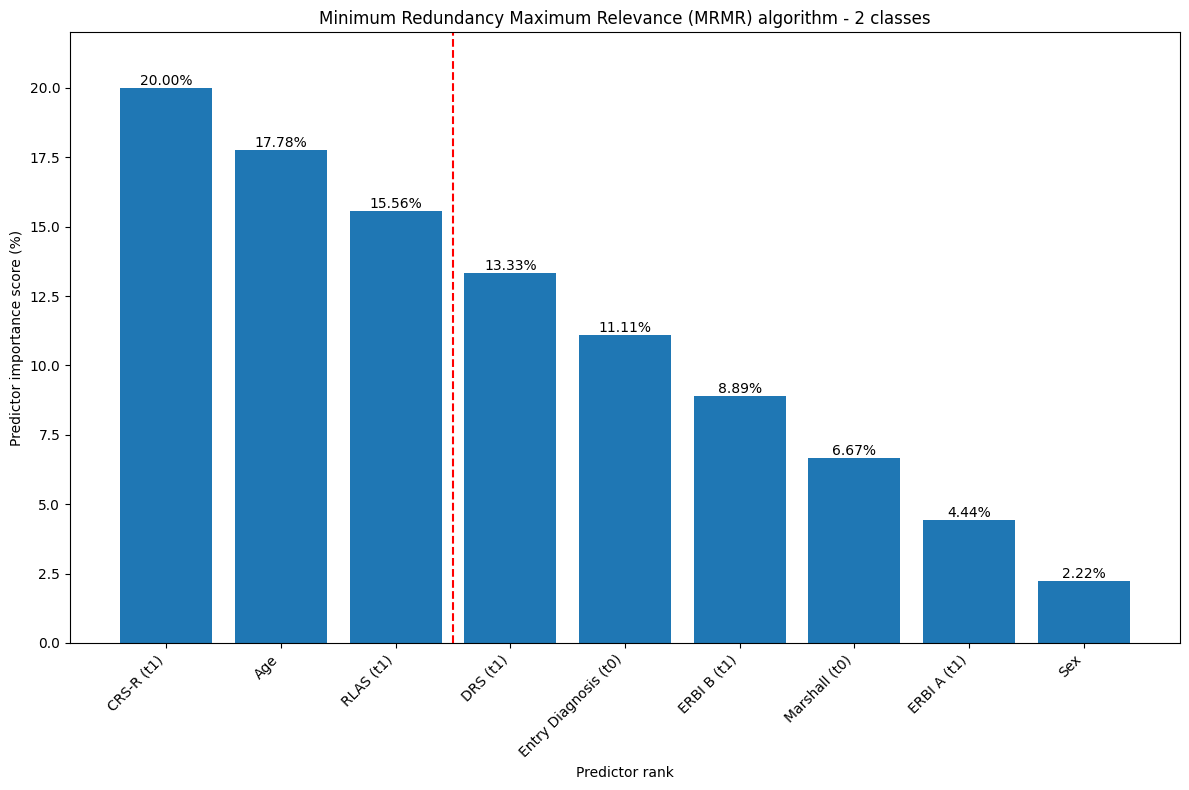

In [21]:
plot_mrmr_feature_importances(X, y)

## Chi-squared Test

In [22]:
# Function to select features using chi2
def select_features_chi2(X, y, k):
    # Convert y to categorical if necessary
    y_cat = pd.Categorical(y).codes
    
    # Use SelectKBest with chi2
    selector = SelectKBest(chi2, k=k)
    selector.fit(X, y_cat)
    
    # Get selected features
    feature_idx = selector.get_support(indices=True)
    selected_features = X.columns[feature_idx]
    
    return selected_features.tolist()

In [23]:
# Function to evaluate models with 10-fold cross-validation
def evaluate_model_cv(model, X, y, selected_features):
    X_selected = X[selected_features]
    scoring = {
        'accuracy': 'accuracy',
        'precision_micro': make_scorer(precision_score, average='micro'),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_micro': make_scorer(recall_score, average='micro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_micro': make_scorer(f1_score, average='micro'),
        'f1_macro': make_scorer(f1_score, average='macro')
    }
    return cross_validate(model, X_selected, y, cv=StratifiedKFold(n_splits=10), scoring=scoring)

In [24]:
    # Function to summarize cross-validation results
    def summarize_cv_results(cv_results):
        return {metric: np.mean(cv_results[f'test_{metric}']) for metric in 
                ['accuracy', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro']}

In [25]:
# Main script
def results_chi2(models, X, y):
    results_list = []
    
    # Transform X and y
    X_transformed, y_transformed = transform_data(X, y)
    
    for k in range(1, 10):
        selected_features = select_features_chi2(X_transformed, y_transformed, k)
        
        for model_name, model in models:
            cv_results = evaluate_model_cv(model, X_transformed, y_transformed, selected_features)
            summary = summarize_cv_results(cv_results)
            
            results_list.append({
                "Model": model_name,
                "K": k,
                "Selected Features": selected_features,
                **summary
            })
    
    return pd.DataFrame(results_list)

In [26]:
# Function to plot feature importances
def plot_chi2_feature_importances(X, y, k=9):
    y_cat = pd.Categorical(y).codes
    X, _ = transform_data(X, y)
    selector = SelectKBest(chi2, k=k)
    selector.fit(X, y_cat)
    
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_
    }).sort_values('Score', ascending=False).head(k)
    
    # Convert scores to percentage
    total_score = feature_scores['Score'].sum()
    feature_scores['Importance'] = feature_scores['Score'] / total_score * 100
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(feature_scores['Feature'], feature_scores['Importance'])
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',
                 ha='center', va='bottom')
    
    plt.xlabel('Predictor rank')
    plt.ylabel('Predictor importance score (%)')
    plt.title('Chi-square Feature Selection - 2 classes')
    plt.xticks(rotation=45, ha='right')
    plt.axvline(x=2.5, color='red', linestyle='--')
    plt.ylim(0, max(feature_scores['Importance']) * 1.1)
    plt.tight_layout()
    plt.show()

In [27]:
results_chi2 = results_chi2(models, X, y)

In [28]:
results_chi2.head()

,Model,K,Selected Features,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,Linear Regression,1,[Entry Diagnosis (t0)],0.7127,0.7127,0.7489,0.7127,0.7393,0.7127,0.7011
1,SVM (RBF),1,[Entry Diagnosis (t0)],0.7127,0.7127,0.7489,0.7127,0.7393,0.7127,0.7011
2,KNN (k=5),1,[Entry Diagnosis (t0)],0.6855,0.6855,0.6907,0.6855,0.6964,0.6855,0.6494
3,Naive Bayes,1,[Entry Diagnosis (t0)],0.7127,0.7127,0.7489,0.7127,0.7393,0.7127,0.7011
4,Decision Tree (max_depth=10),1,[Entry Diagnosis (t0)],0.7127,0.7127,0.7489,0.7127,0.7393,0.7127,0.7011


In [29]:
best_results_chi2 = (results_chi2.loc[results_chi2.groupby('Model')['accuracy'].idxmax()]
                .sort_values(by="accuracy", ascending=False)
                .reset_index(drop=True))
best_results_chi2["Rank"] = best_results_chi2.index + 1
best_results_chi2 = best_results_chi2[["Rank", "Model", "K", "accuracy", "precision_micro", "precision_macro", 
                             "recall_micro", "recall_macro", "f1_micro", "f1_macro"]]
pd.set_option('display.float_format', lambda x: '%.4f' % x)
best_results_chi2

,Rank,Model,K,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,1,Linear Regression,3,0.8527,0.8527,0.8745,0.8527,0.8345,0.8527,0.8380
1,2,KNN (k=5),8,0.8518,0.8518,0.8698,0.8518,0.8292,0.8518,0.8367
2,3,SVM (RBF),5,0.8427,0.8427,0.8679,0.8427,0.8262,0.8427,0.8281
3,4,Naive Bayes,4,0.8227,0.8227,0.8274,0.8227,0.8202,0.8227,0.8094
4,5,Decision Tree (max_depth=10),5,0.8127,0.8127,0.8560,0.8127,0.7970,0.8127,0.7914


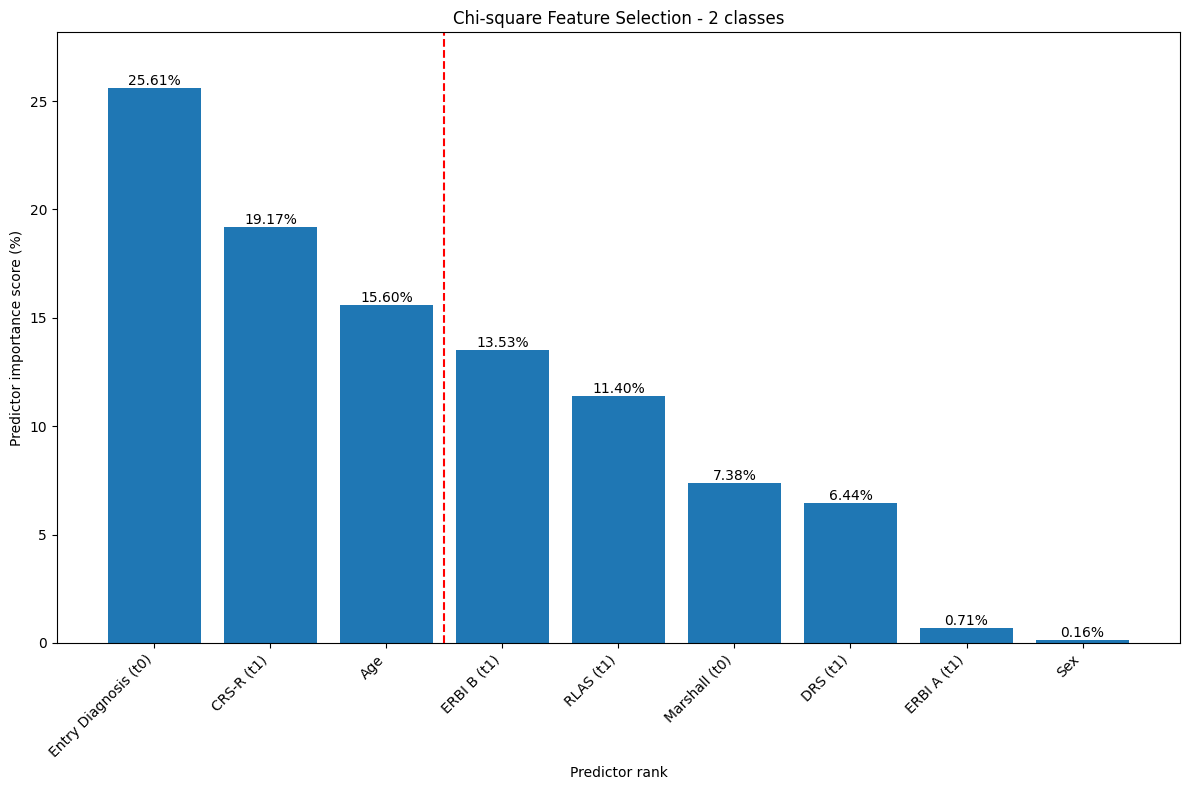

In [30]:
plot_chi2_feature_importances(X, y)

## Pearson Correlation

In [31]:
def select_features_pearson(X, threshold):
    col_corr = set()
    corr_matrix = X.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    selected_features = [col for col in X.columns if col not in col_corr]
    return selected_features

In [32]:
# Function to evaluate models with 10-fold cross-validation
def evaluate_model_cv(model, X, y, selected_features):
    X_selected = X[selected_features]
    scoring = {
        'accuracy': 'accuracy',
        'precision_micro': make_scorer(precision_score, average='micro'),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_micro': make_scorer(recall_score, average='micro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_micro': make_scorer(f1_score, average='micro'),
        'f1_macro': make_scorer(f1_score, average='macro')
    }
    return cross_validate(model, X_selected, y, cv=StratifiedKFold(n_splits=10), scoring=scoring)

In [33]:
# Function to summarize cross-validation results
def summarize_cv_results(cv_results):
    return {metric: np.mean(cv_results[f'test_{metric}']) for metric in 
            ['accuracy', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro']}

In [34]:
# Main script
def results_pearson(models, X, y, thresholds):
    results_list = []
    
    # Transform X and y
    X_transformed, y_transformed = transform_data(X, y)
    
    for threshold in thresholds:
        selected_features = select_features_pearson(X_transformed, threshold)
        
        for model_name, model in models:
            if len(selected_features) > 0:
                cv_results = evaluate_model_cv(model, X_transformed, y_transformed, selected_features)
                summary = summarize_cv_results(cv_results)
                
                results_list.append({
                    "Model": model_name,
                    "Threshold": threshold,
                    "Number of Features": len(selected_features),
                    "Selected Features": selected_features,
                    **summary
                })
    
    return pd.DataFrame(results_list)

In [35]:
def plot_pearson_feature_importances(X, threshold):
    corr_matrix = X.corr().abs()
    
    # Tính trung bình tương quan của mỗi đặc trưng với các đặc trưng khác
    avg_correlation = corr_matrix.mean().sort_values(ascending=False)
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_correlation.index, y=avg_correlation.values)
    plt.title('Feature Importance based on Average Pearson Correlation')
    plt.xlabel('Features')
    plt.ylabel('Average Absolute Correlation')
    plt.xticks(rotation=90)
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [36]:
thresholds = [0.1, 0.2, 0.3, 0.5, 0.6, 0.9, 1.0]

In [37]:
results_pearson = results_pearson(models, X, y, thresholds)

In [38]:
results_pearson.head()

,Model,Threshold,Number of Features,Selected Features,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,Linear Regression,0.1000,2,"[Age, Sex]",0.6673,0.6673,0.6485,0.6673,0.6083,0.6673,0.5723
1,SVM (RBF),0.1000,2,"[Age, Sex]",0.7455,0.7455,0.7607,0.7455,0.7113,0.7455,0.7111
2,KNN (k=5),0.1000,2,"[Age, Sex]",0.6973,0.6973,0.7189,0.6973,0.6667,0.6973,0.6476
3,Naive Bayes,0.1000,2,"[Age, Sex]",0.7182,0.7182,0.7431,0.7182,0.7137,0.7182,0.7013
4,Decision Tree (max_depth=10),0.1000,2,"[Age, Sex]",0.6473,0.6473,0.5878,0.6473,0.5946,0.6473,0.5700


In [39]:
best_results_pearson = (results_pearson.loc[results_pearson.groupby('Model')['accuracy'].idxmax()]
                .sort_values(by="accuracy", ascending=False)
                .reset_index(drop=True))
best_results_pearson["Rank"] = best_results_pearson.index + 1
best_results_pearson = best_results_pearson[["Rank", "Model", "Threshold", "Selected Features", 
                             "accuracy", "precision_micro", "precision_macro", 
                             "recall_micro", "recall_macro", "f1_micro", "f1_macro"]]
pd.set_option('display.float_format', lambda x: '%.4f' % x)
best_results_pearson

,Rank,Model,Threshold,Selected Features,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,1,KNN (k=5),0.5000,"[Age, Sex, Marshall (t0), Entry Diagnosis (t0)...",0.8245,0.8245,0.8345,0.8245,0.8065,0.8245,0.8044
1,2,SVM (RBF),1.0000,"[Age, Sex, Marshall (t0), Entry Diagnosis (t0)...",0.8236,0.8236,0.8480,0.8236,0.8107,0.8236,0.8021
2,3,Linear Regression,1.0000,"[Age, Sex, Marshall (t0), Entry Diagnosis (t0)...",0.8036,0.8036,0.8233,0.8036,0.7857,0.8036,0.7847
3,4,Naive Bayes,0.9000,"[Age, Sex, Marshall (t0), Entry Diagnosis (t0)...",0.7836,0.7836,0.8210,0.7836,0.7607,0.7836,0.7506
4,5,Decision Tree (max_depth=10),0.6000,"[Age, Sex, Marshall (t0), Entry Diagnosis (t0)...",0.7755,0.7755,0.8104,0.7755,0.7643,0.7755,0.7493


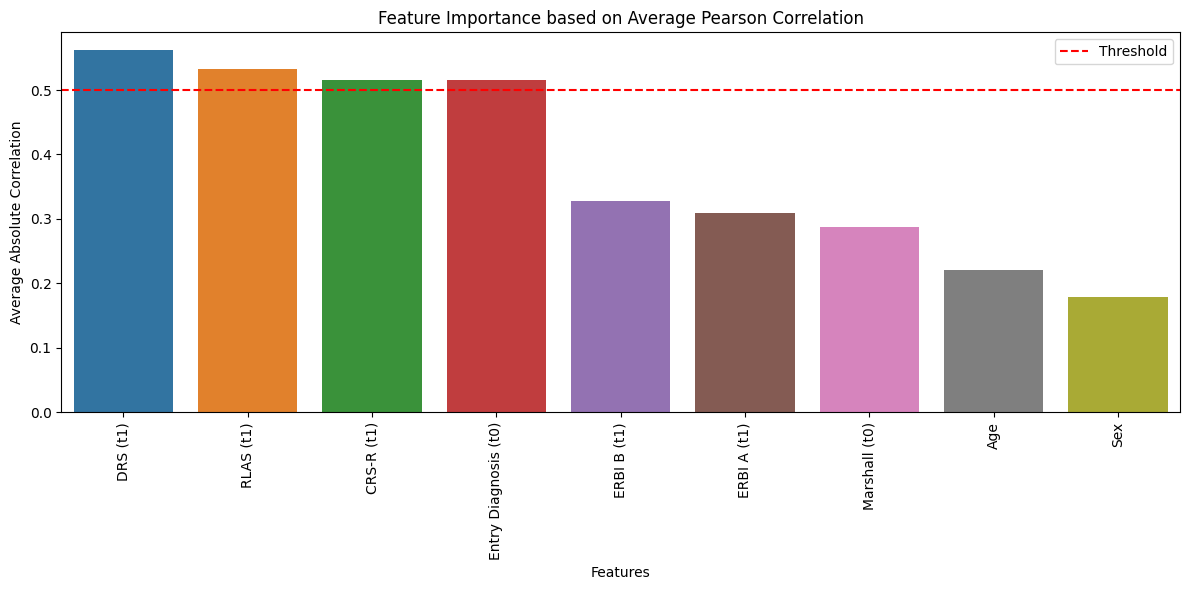

In [40]:
plot_pearson_feature_importances(X, threshold=0.5)

## SFS

In [41]:
X_transformed, y_transformed = transform_data(X, y)
                                              
results_sfs = []

# Fit the selector and calculate custom scores for each model
for model_name, model in models:
    sfs = SFS(estimator=model,
              k_features=(1, 9),
              forward=True,
              scoring='accuracy',
              cv=StratifiedKFold(n_splits=10))
    sfs = sfs.fit(X_transformed, y_transformed)
    # Display the best score and selected features
    print(f'\nModel: {model_name}')
    print('Best acc score: %.4f' % sfs.k_score_)
    print('Best subset (indices):', sfs.k_feature_idx_)
    print('Best subset (corresponding names):', sfs.k_feature_names_)
                                              
    # Lưu kết quả vào danh sách
    for k, score in zip(range(1, X_transformed.shape[1] + 1), sfs.get_metric_dict().values()):
        results_sfs.append({
            "Model": model_name,
            "Number of Features (K)": k,
            "Accuracy": score['avg_score']
        })
                                              


Model: Linear Regression
Best acc score: 0.8518
Best subset (indices): (0, 3, 5)
Best subset (corresponding names): ('Age', 'Entry Diagnosis (t0)', 'RLAS (t1)')

Model: SVM (RBF)
Best acc score: 0.8518
Best subset (indices): (0, 3, 4, 5, 6)
Best subset (corresponding names): ('Age', 'Entry Diagnosis (t0)', 'CRS-R (t1)', 'RLAS (t1)', 'DRS (t1)')

Model: KNN (k=5)
Best acc score: 0.8527
Best subset (indices): (0, 1, 3, 5, 8)
Best subset (corresponding names): ('Age', 'Sex', 'Entry Diagnosis (t0)', 'RLAS (t1)', 'ERBI B (t1)')

Model: Naive Bayes
Best acc score: 0.8136
Best subset (indices): (0, 5, 6)
Best subset (corresponding names): ('Age', 'RLAS (t1)', 'DRS (t1)')

Model: Decision Tree (max_depth=10)
Best acc score: 0.8218
Best subset (indices): (0, 1, 3, 4, 5, 6, 7, 8)
Best subset (corresponding names): ('Age', 'Sex', 'Entry Diagnosis (t0)', 'CRS-R (t1)', 'RLAS (t1)', 'DRS (t1)', 'ERBI A (t1)', 'ERBI B (t1)')


In [42]:
results_sfs_df = pd.DataFrame(results_sfs)

In [43]:
results_sfs_df.head()

,Model,Number of Features (K),Accuracy
0,Linear Regression,1,0.7245
1,Linear Regression,2,0.7836
2,Linear Regression,3,0.8518
3,Linear Regression,4,0.8518
4,Linear Regression,5,0.8518


## SBS

In [44]:
X_transformed, y_transformed = transform_data(X, y)

results_sbs = []

# Fit the selector and calculate custom scores for each model
for model_name, model in models:
    sbs = SFS(estimator=model,
              k_features=(1, 9),
              forward=False,
              scoring='accuracy',
              cv=StratifiedKFold(n_splits=10))
    sbs = sbs.fit(X_transformed, y_transformed)
    # Display the best score and selected features
    print(f'\nModel: {model_name}')
    print('Best acc score: %.4f' % sbs.k_score_)
    print('Best subset (indices):', sbs.k_feature_idx_)
    print('Best subset (corresponding names):', sbs.k_feature_names_)
    
    # Lưu kết quả vào danh sách
    for k, score in zip(range(X_transformed.shape[1], 0, -1), sbs.get_metric_dict().values()):  # Duyệt ngược từ số features tối đa
        results_sbs.append({
            "Model": model_name,
            "Number of Features (K)": k,
            "Accuracy": score['avg_score']  # Giả sử bạn dùng 'accuracy'
        })


Model: Linear Regression
Best acc score: 0.8518
Best subset (indices): (0, 1, 3, 4, 5, 6, 8)
Best subset (corresponding names): ('Age', 'Sex', 'Entry Diagnosis (t0)', 'CRS-R (t1)', 'RLAS (t1)', 'DRS (t1)', 'ERBI B (t1)')

Model: SVM (RBF)
Best acc score: 0.8527
Best subset (indices): (0, 1, 2, 4, 6, 8)
Best subset (corresponding names): ('Age', 'Sex', 'Marshall (t0)', 'CRS-R (t1)', 'DRS (t1)', 'ERBI B (t1)')

Model: KNN (k=5)
Best acc score: 0.8609
Best subset (indices): (0, 2, 4, 5, 6, 7, 8)
Best subset (corresponding names): ('Age', 'Marshall (t0)', 'CRS-R (t1)', 'RLAS (t1)', 'DRS (t1)', 'ERBI A (t1)', 'ERBI B (t1)')

Model: Naive Bayes
Best acc score: 0.8127
Best subset (indices): (0, 1, 2, 3, 5, 8)
Best subset (corresponding names): ('Age', 'Sex', 'Marshall (t0)', 'Entry Diagnosis (t0)', 'RLAS (t1)', 'ERBI B (t1)')

Model: Decision Tree (max_depth=10)
Best acc score: 0.8218
Best subset (indices): (0, 1, 3, 4, 5, 6)
Best subset (corresponding names): ('Age', 'Sex', 'Entry Diagnosis

In [45]:
results_sbs_df = pd.DataFrame(results_sbs)

In [46]:
results_sbs_df.head()

,Model,Number of Features (K),Accuracy
0,Linear Regression,9,0.8036
1,Linear Regression,8,0.8418
2,Linear Regression,7,0.8518
3,Linear Regression,6,0.8518
4,Linear Regression,5,0.8518


## Visualization

### 1. Without Feature Selection


In [47]:
def plot_results_no_fs(results_df):
    metrics = ['accuracy']
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(data=results_df, x='Model', y=metric, palette='viridis')
        plt.title(f'{metric.capitalize()} for Different Models (No Feature Selection)', fontsize=16)
        plt.xlabel('Model', fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        
        # Adding detail numbers on bars
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height:.4f}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points', 
                        fontsize=12, color='black', weight='bold')
        
        # Identify the highest accuracy and the corresponding model
        max_accuracy = results_df[metric].max()
        best_model = results_df.loc[results_df[metric].idxmax(), 'Model']
        
        plt.tight_layout()

        # Adding annotation outside the plot area
        plt.figtext(0.5, -0.05, f'Best Model: {best_model}, Accuracy: {max_accuracy:.4f}', 
                    wrap=True, horizontalalignment='center', fontsize=14, color='red', weight='bold')
        
        plt.show()

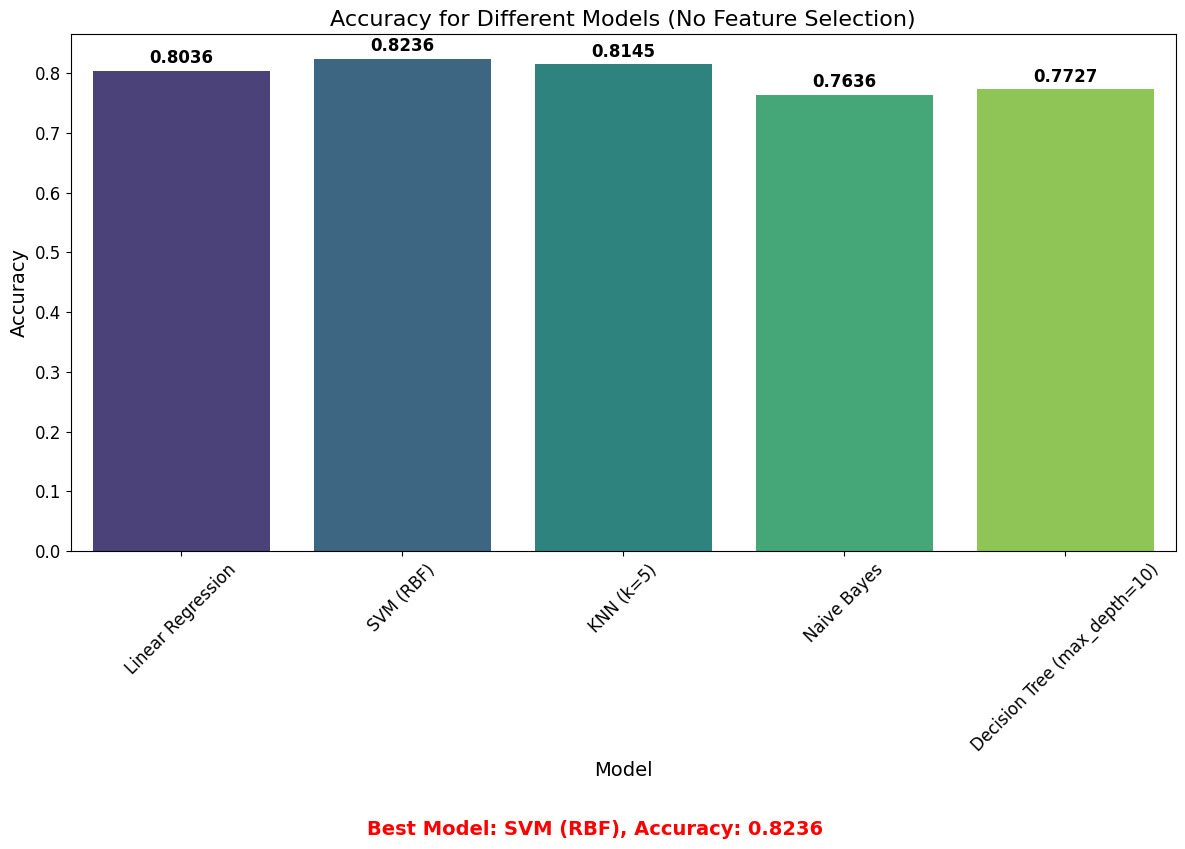

In [48]:
plot_results_no_fs(results_without_fs)

### 2. MRMR

In [49]:
def plot_results_mrmr(results_df):
    metrics = ['accuracy']
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        ax = sns.lineplot(data=results_df, x='K', y=metric, hue='Model', marker='o', palette='tab10')
        plt.title(f'{metric.capitalize()} vs. Number of Features (MRMR)', fontsize=16)
        plt.xlabel('Number of Features (K)', fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title='Model', fontsize=12, title_fontsize='13')
        
        # Adding detail numbers on points
        for line in ax.lines:
            for x, y in zip(line.get_xdata(), line.get_ydata()):
                ax.annotate(f'{y:.4f}', 
                            (x, y), 
                            textcoords="offset points", 
                            xytext=(0, 5), 
                            ha='center', fontsize=10, color='black', weight='bold')

        # Finding and annotating the best score
        best_score = results_df[metric].max()
        best_row = results_df.loc[results_df[metric].idxmax()]
        best_model = best_row['Model']
        best_k = best_row['K']
        
        plt.figtext(0.5, -0.05, f'Best {metric.capitalize()}: {best_score:.4f} (Model: {best_model}, K={best_k})',
                    wrap=True, horizontalalignment='center', fontsize=14, color='red', weight='bold')
        
        plt.grid(True)
        plt.tight_layout()
        plt.show()

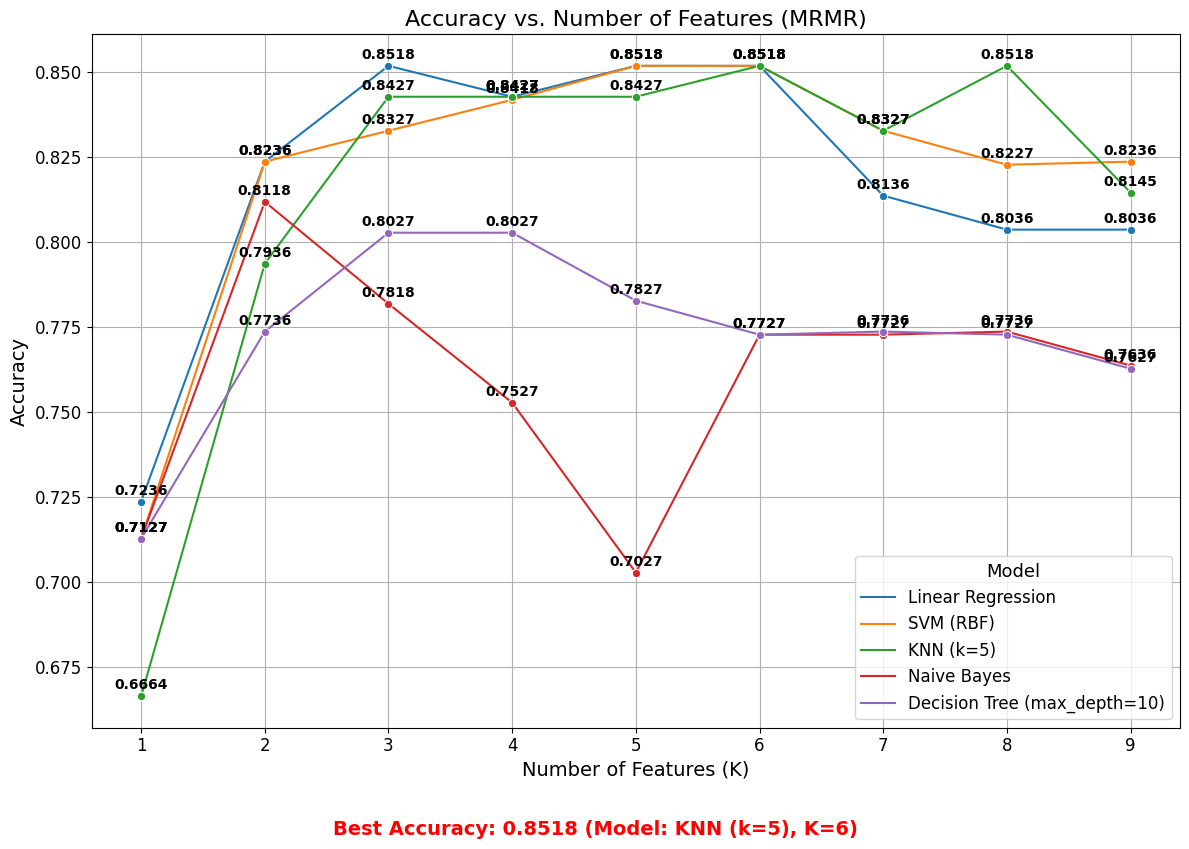

In [50]:
plot_results_mrmr(results_mrmr)

### 3. Chi-squared Test

In [51]:
def plot_results_chi2(results_df):
    metrics = ['accuracy']
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        ax = sns.lineplot(data=results_df, x='K', y=metric, hue='Model', marker='o', palette='tab10')
        plt.title(f'{metric.capitalize()} vs. Number of Features (Chi2)', fontsize=16)
        plt.xlabel('Number of Features (K)', fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title='Model', fontsize=12, title_fontsize='13')
        
        # Adding detail numbers on points
        for line in ax.lines:
            for x, y in zip(line.get_xdata(), line.get_ydata()):
                ax.annotate(f'{y:.4f}', 
                            (x, y), 
                            textcoords="offset points", 
                            xytext=(0, 5), 
                            ha='center', fontsize=10, color='black', weight='bold')

        # Finding and annotating the best score
        best_score = results_df[metric].max()
        best_row = results_df.loc[results_df[metric].idxmax()]
        best_model = best_row['Model']
        best_k = best_row['K']
        
        plt.figtext(0.5, -0.05, f'Best {metric.capitalize()}: {best_score:.4f} (Model: {best_model}, K={best_k})',
                    wrap=True, horizontalalignment='center', fontsize=14, color='red', weight='bold')
        
        plt.grid(True)
        plt.tight_layout()
        plt.show()

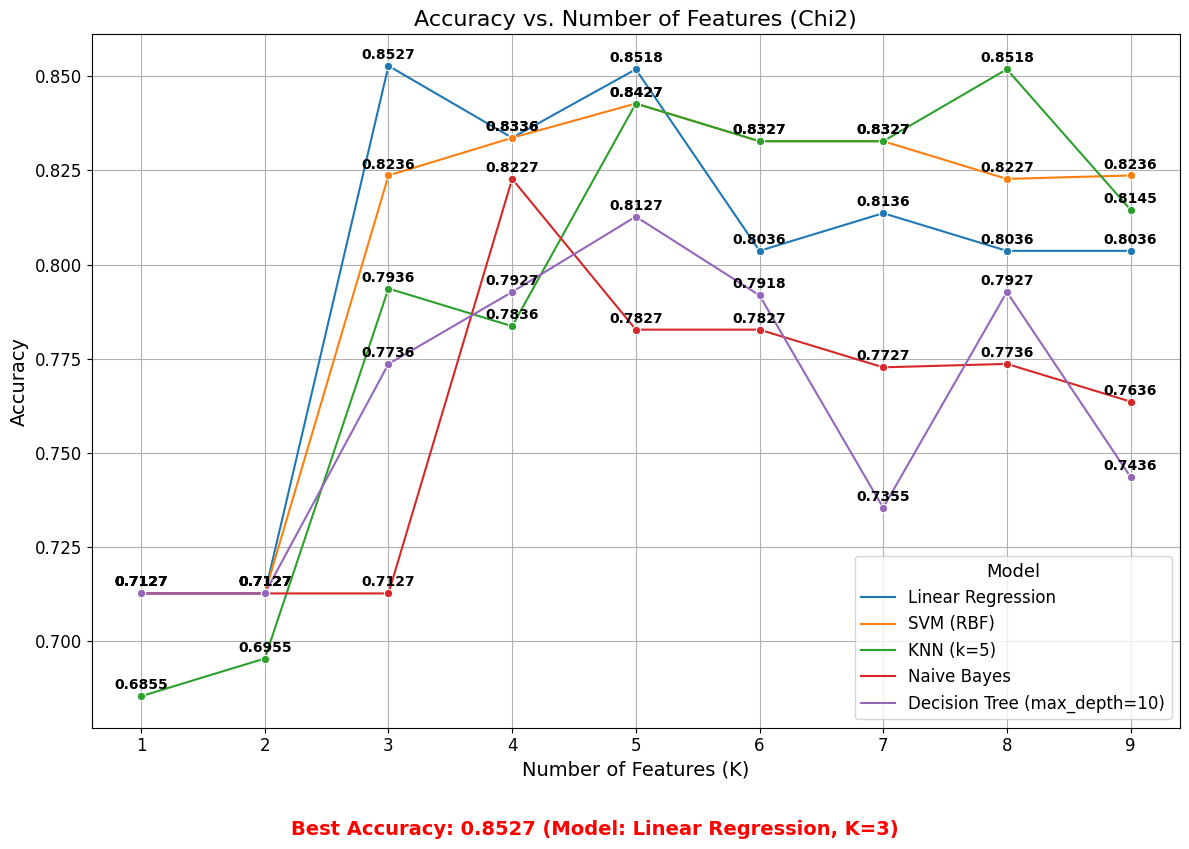

In [52]:
plot_results_chi2(results_chi2)

### 4. Pearson Correlation

In [53]:
def plot_results_pearson(results_df):
    metrics = ['accuracy']  # Hoặc các metrics khác bạn muốn hiển thị
    for metric in metrics:
        plt.figure(figsize=(12, 8))

        # Lọc các mô hình duy nhất
        unique_models = results_df['Model'].unique()
        palette = sns.color_palette("tab10", n_colors=len(unique_models))  # Tạo bảng màu

        for i, model in enumerate(unique_models):
            model_data = results_df[results_df['Model'] == model]  # Lọc dữ liệu cho từng mô hình

            # Vẽ biểu đồ đường (không có vùng tô)
            sns.lineplot(
                data=model_data,
                x='Threshold',  # Sử dụng 'Threshold' làm trục X
                y=metric,
                marker='o',
                label=model,
                color=palette[i],  # Gán màu cho từng mô hình
                ci=None  # Loại bỏ vùng tin cậy (confidence interval)
            )

            # Thêm số chi tiết trên mỗi điểm
            for x, y in zip(model_data['Threshold'], model_data[metric]):
                plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0, 5),
                             ha='center', fontsize=10, color='black', weight='bold')

        # Tìm và chú thích kết quả tốt nhất
        best_score = results_df[metric].max()
        best_row = results_df.loc[results_df[metric].idxmax()]
        best_model = best_row['Model']
        best_threshold = best_row['Threshold']
        
        plt.figtext(0.5, -0.05, f'Best {metric.capitalize()}: {best_score:.4f} (Model: {best_model}, Threshold={best_threshold})',
                    wrap=True, horizontalalignment='center', fontsize=14, color='red', weight='bold')

        plt.title(f'{metric.capitalize()} vs. Pearson Correlation Threshold', fontsize=16)  
        plt.xlabel('Pearson Correlation Threshold', fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title='Model', fontsize=12, title_fontsize=13)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


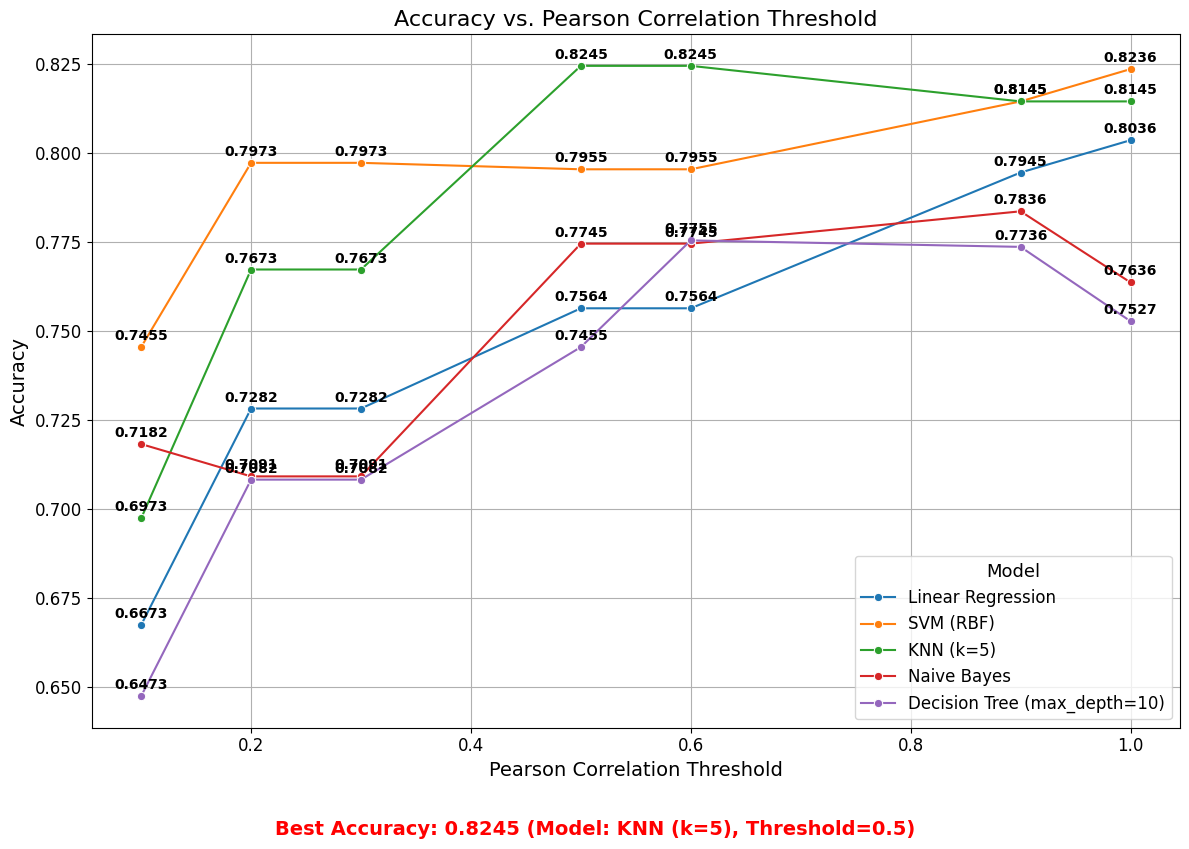

In [54]:
plot_results_pearson(results_pearson)

### 5. SFS

In [55]:
def plot_results_sfs(results_df):
    plt.figure(figsize=(12, 8))
    unique_models = results_df['Model'].unique()
    palette = sns.color_palette("tab10", n_colors=len(unique_models))  # Tạo bảng màu

    for i, model in enumerate(unique_models):
        model_data = results_df[results_df['Model'] == model]  # Lọc dữ liệu cho từng mô hình
        sns.lineplot(
            data=model_data,
            x='Number of Features (K)',
            y='Accuracy',  # Giả sử bạn dùng 'accuracy'
            marker='o',
            label=model,
            color=palette[i]
        )

        # Thêm số chi tiết trên mỗi điểm
        for x, y in zip(model_data['Number of Features (K)'], model_data['Accuracy']):
            plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0, 5),
                         ha='center', fontsize=10, color='black', weight='bold')

    # Tìm và chú thích kết quả tốt nhất
    best_score = results_df['Accuracy'].max()
    best_row = results_df.loc[results_df['Accuracy'].idxmax()]
    best_model = best_row['Model']
    best_k = best_row['Number of Features (K)']
    
    plt.figtext(0.5, -0.05, f'Best Accuracy: {best_score:.4f} (Model: {best_model}, Number of Features (K)={best_k})',
                wrap=True, horizontalalignment='center', fontsize=14, color='red', weight='bold')

    plt.title('Accuracy vs. Number of Features (SFS)', fontsize=16)
    plt.xlabel('Number of Features (K)', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Model', fontsize=12, title_fontsize=13)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

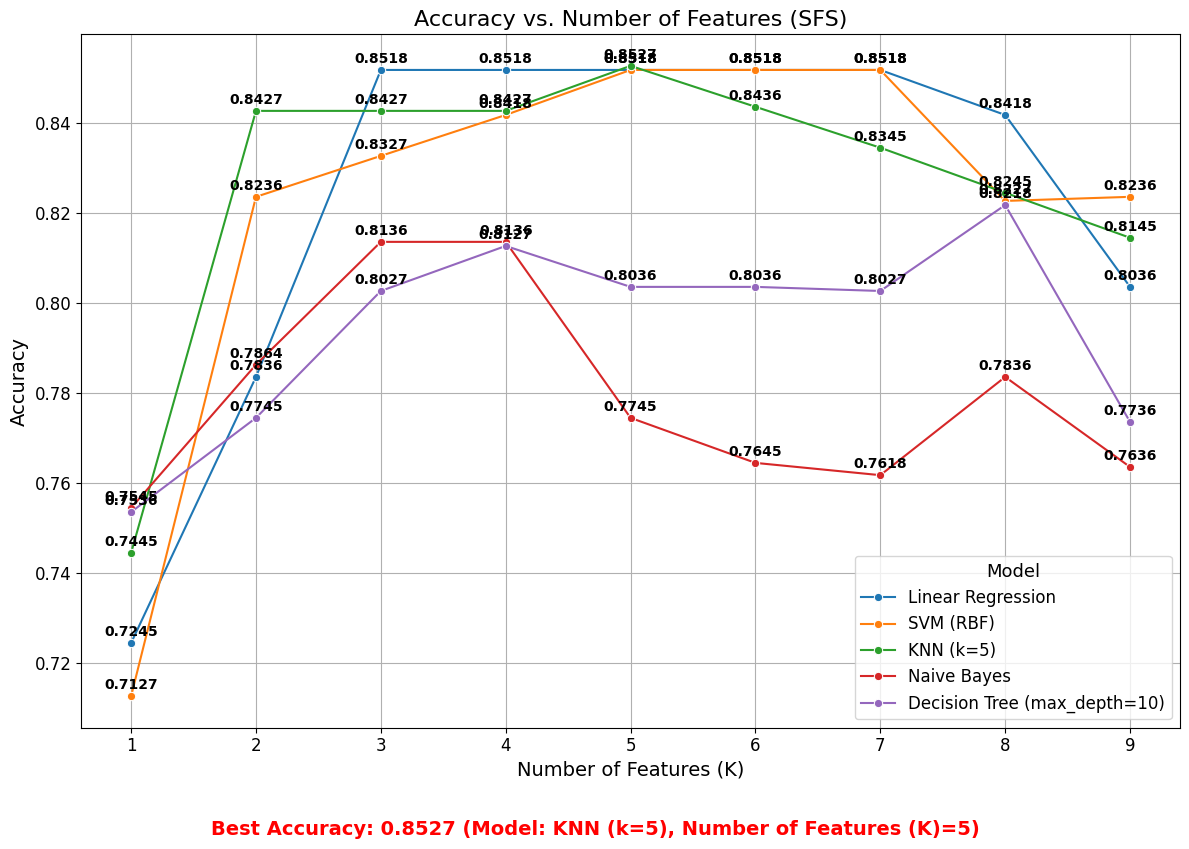

In [56]:
plot_results_sfs(results_sfs_df)

### 6. SBS

In [57]:
def plot_results_sbs(results_df):
    plt.figure(figsize=(12, 8))
    unique_models = results_df['Model'].unique()
    palette = sns.color_palette("tab10", n_colors=len(unique_models))  # Tạo bảng màu

    for i, model in enumerate(unique_models):
        model_data = results_df[results_df['Model'] == model]  # Lọc dữ liệu cho từng mô hình
        sns.lineplot(
            data=model_data,
            x='Number of Features (K)',
            y='Accuracy',  # Giả sử bạn dùng 'accuracy'
            marker='o',
            label=model,
            color=palette[i]
        )

        # Thêm số chi tiết trên mỗi điểm
        for x, y in zip(model_data['Number of Features (K)'], model_data['Accuracy']):
            plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0, 5),
                         ha='center', fontsize=10, color='black', weight='bold')

    # Tìm và chú thích kết quả tốt nhất
    best_score = results_df['Accuracy'].max()
    best_row = results_df.loc[results_df['Accuracy'].idxmax()]
    best_model = best_row['Model']
    best_k = best_row['Number of Features (K)']
    
    plt.figtext(0.5, -0.05, f'Best Accuracy: {best_score:.4f} (Model: {best_model}, Number of Features (K)={best_k})',
                wrap=True, horizontalalignment='center', fontsize=14, color='red', weight='bold')

    plt.title('Accuracy vs. Number of Features (SBS)', fontsize=16)
    plt.xlabel('Number of Features (K)', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().invert_xaxis()  # Đảo ngược trục x cho SBS
    plt.legend(title='Model', fontsize=12, title_fontsize=13)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

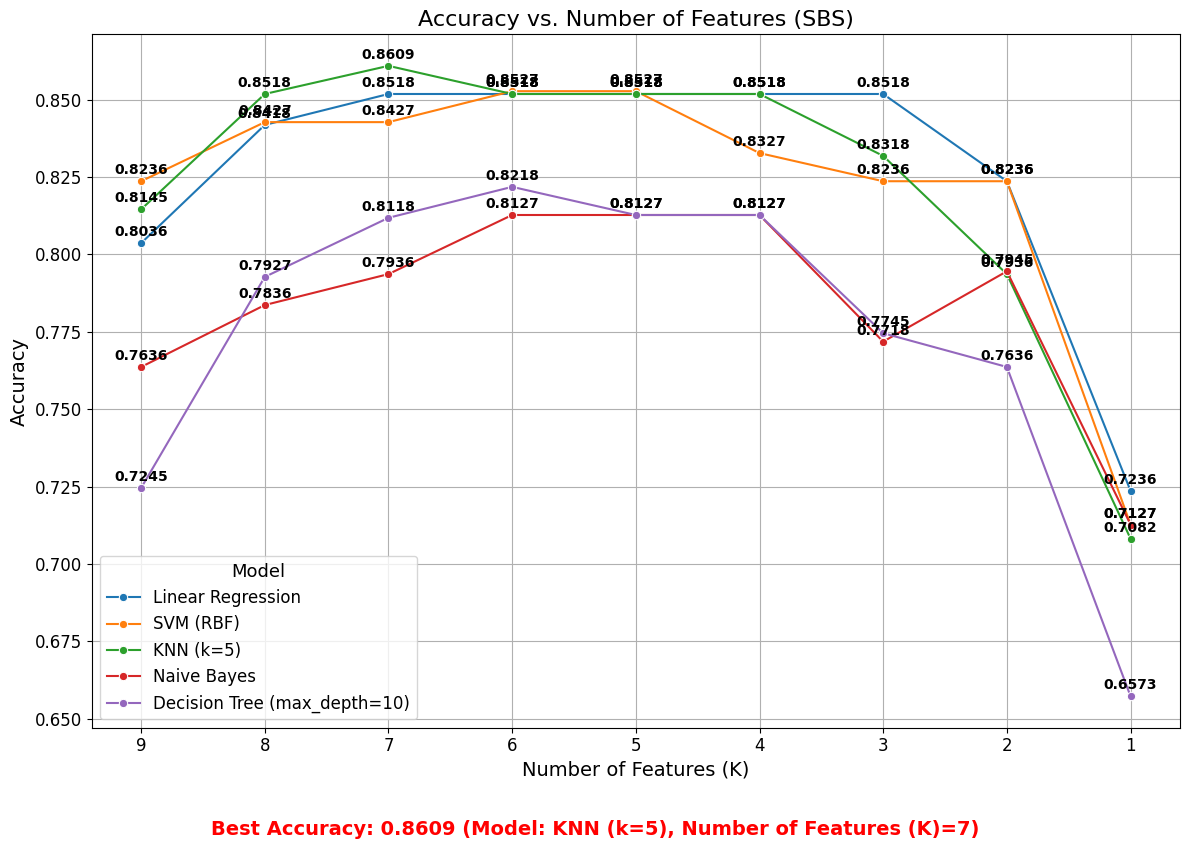

In [58]:
plot_results_sbs(results_sbs_df)

---
# LOO CV

## Run Model without Feature Selection

In [59]:
def evaluate_model_cv(model, X, y):
    scoring = {
        'accuracy': 'accuracy',
        'precision_micro': make_scorer(precision_score, average='micro'),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_micro': make_scorer(recall_score, average='micro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_micro': make_scorer(f1_score, average='micro'),
        'f1_macro': make_scorer(f1_score, average='macro')
    }
    return cross_validate(model, X, y, cv=LeaveOneOut(), scoring=scoring)

In [60]:
def summarize_cv_results(cv_results):
    return {metric: np.mean(cv_results[f'test_{metric}']) for metric in 
            ['accuracy', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro']}

In [61]:
def run_models_without_fs(models, X, y):
    results_list = []
    
    X_transformed, y_transformed = transform_data(X, y)
    
    for model_name, model in models:
        cv_results = evaluate_model_cv(model, X_transformed, y_transformed)
        summary = summarize_cv_results(cv_results)
        
        results_list.append({
            "Model": model_name,
            "Number of Features": X.shape[1],
            **summary
        })
    
    return pd.DataFrame(results_list)

In [62]:
results_without_fs = run_models_without_fs(models, X, y)

In [63]:
results_without_fs

,Model,Number of Features,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,Linear Regression,9,0.7843,0.7843,0.7843,0.7843,0.7843,0.7843,0.7843
1,SVM (RBF),9,0.8137,0.8137,0.8137,0.8137,0.8137,0.8137,0.8137
2,KNN (k=5),9,0.8431,0.8431,0.8431,0.8431,0.8431,0.8431,0.8431
3,Naive Bayes,9,0.7647,0.7647,0.7647,0.7647,0.7647,0.7647,0.7647
4,Decision Tree (max_depth=10),9,0.7157,0.7157,0.7157,0.7157,0.7157,0.7157,0.7157


## Minimum Redundancy Maximum Relevance (MRMR)

In [64]:
def select_features_mrmr(X, y, k):
    return mrmr_classif(X=X, y=y, K=k)

In [65]:
# Function to evaluate models with 10-fold cross-validation
def evaluate_model_cv(model, X, y, selected_features):
    X_selected = X[selected_features]
    scoring = {
        'accuracy': 'accuracy',
        'precision_micro': make_scorer(precision_score, average='micro'),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_micro': make_scorer(recall_score, average='micro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_micro': make_scorer(f1_score, average='micro'),
        'f1_macro': make_scorer(f1_score, average='macro')
    }
    return cross_validate(model, X_selected, y, cv=LeaveOneOut(), scoring=scoring)

In [66]:
# Function to summarize cross-validation results
def summarize_cv_results(cv_results):
    return {metric: np.mean(cv_results[f'test_{metric}']) for metric in 
            ['accuracy', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro']}

In [67]:
# Main script
def results_mrmr(models, X, y):
    results_list = []

    # Transform X and y
    X_transformed, y_transformed = transform_data(X, y)    
    
    for k in range(1, 10):
        selected_features = select_features_mrmr(X_transformed, y_transformed, k)
        
        for model_name, model in models:
            cv_results = evaluate_model_cv(model, X_transformed, y_transformed, selected_features)
            summary = summarize_cv_results(cv_results)
            
            results_list.append({
                "Model": model_name,
                "K": k,
                "Selected Features": selected_features,
                **summary
            })
    
    return pd.DataFrame(results_list)

In [68]:
# Function to plot feature importances
def plot_mrmr_feature_importances(X, y, k=9):
    selected_features = select_features_mrmr(X, y, k)
    
    total = sum(range(1, k+1))
    importances = [(k - i) / total * 100 for i in range(k)]
    
    feature_importances = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    })
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(feature_importances['Feature'], feature_importances['Importance'])
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',
                 ha='center', va='bottom')
    
    plt.xlabel('Predictor rank')
    plt.ylabel('Predictor importance score (%)')
    plt.title('Minimum Redundancy Maximum Relevance (MRMR) algorithm - 2 classes')
    plt.xticks(rotation=45, ha='right')
    plt.axvline(x=2.5, color='red', linestyle='--')
    plt.ylim(0, max(importances) * 1.1)
    plt.tight_layout()
    plt.show()


In [69]:
results_mrmr = results_mrmr(models, X, y)

100%|██████████| 9/9 [00:01<00:00,  7.26it/s]


In [70]:
results_mrmr.head()

,Model,K,Selected Features,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,Linear Regression,1,[CRS-R (t1)],0.7255,0.7255,0.7255,0.7255,0.7255,0.7255,0.7255
1,SVM (RBF),1,[CRS-R (t1)],0.7157,0.7157,0.7157,0.7157,0.7157,0.7157,0.7157
2,KNN (k=5),1,[CRS-R (t1)],0.6961,0.6961,0.6961,0.6961,0.6961,0.6961,0.6961
3,Naive Bayes,1,[CRS-R (t1)],0.7157,0.7157,0.7157,0.7157,0.7157,0.7157,0.7157
4,Decision Tree (max_depth=10),1,[CRS-R (t1)],0.7353,0.7353,0.7353,0.7353,0.7353,0.7353,0.7353


In [71]:
best_results_mrmr = (results_mrmr.loc[results_mrmr.groupby('Model')['accuracy'].idxmax()]
                .sort_values(by="accuracy", ascending=False)
                .reset_index(drop=True))
best_results_mrmr["Rank"] = best_results_mrmr.index + 1
best_results_mrmr = best_results_mrmr[["Rank", "Model", "K", "accuracy", "precision_micro", "precision_macro", 
                             "recall_micro", "recall_macro", "f1_micro", "f1_macro"]]

pd.set_option('display.float_format', lambda x: '%.4f' % x)
best_results_mrmr

,Rank,Model,K,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,1,KNN (k=5),8,0.8529,0.8529,0.8529,0.8529,0.8529,0.8529,0.8529
1,2,SVM (RBF),5,0.8529,0.8529,0.8529,0.8529,0.8529,0.8529,0.8529
2,3,Linear Regression,3,0.8529,0.8529,0.8529,0.8529,0.8529,0.8529,0.8529
3,4,Naive Bayes,2,0.8235,0.8235,0.8235,0.8235,0.8235,0.8235,0.8235
4,5,Decision Tree (max_depth=10),3,0.7941,0.7941,0.7941,0.7941,0.7941,0.7941,0.7941


100%|██████████| 9/9 [00:01<00:00,  6.91it/s]


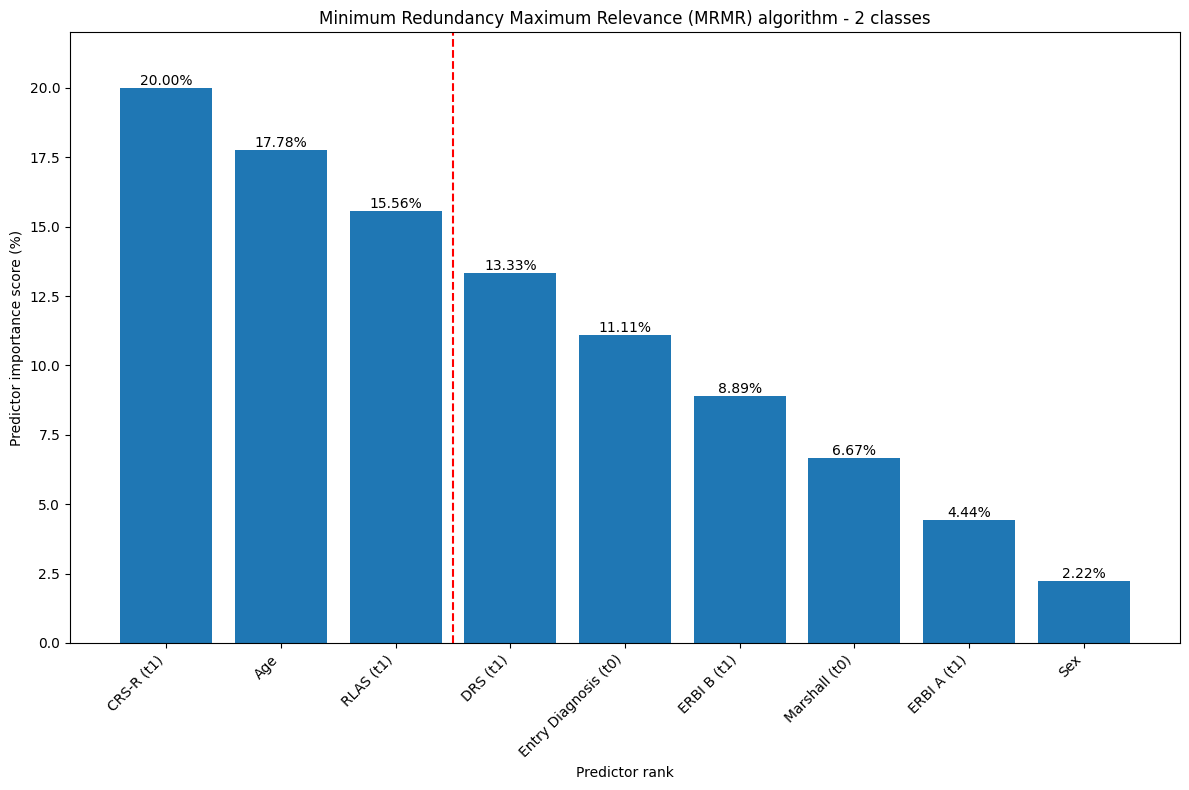

In [72]:
plot_mrmr_feature_importances(X, y)

## Chi-squared Test

In [73]:
# Function to select features using chi2
def select_features_chi2(X, y, k):
    # Convert y to categorical if necessary
    y_cat = pd.Categorical(y).codes
    
    # Use SelectKBest with chi2
    selector = SelectKBest(chi2, k=k)
    selector.fit(X, y_cat)
    
    # Get selected features
    feature_idx = selector.get_support(indices=True)
    selected_features = X.columns[feature_idx]
    
    return selected_features.tolist()

In [74]:
# Function to evaluate models with 10-fold cross-validation
def evaluate_model_cv(model, X, y, selected_features):
    X_selected = X[selected_features]
    scoring = {
        'accuracy': 'accuracy',
        'precision_micro': make_scorer(precision_score, average='micro'),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_micro': make_scorer(recall_score, average='micro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_micro': make_scorer(f1_score, average='micro'),
        'f1_macro': make_scorer(f1_score, average='macro')
    }
    return cross_validate(model, X_selected, y, cv=LeaveOneOut(), scoring=scoring)

In [75]:
# Function to summarize cross-validation results
def summarize_cv_results(cv_results):
    return {metric: np.mean(cv_results[f'test_{metric}']) for metric in 
            ['accuracy', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro']}

In [76]:
# Main script
def results_chi2(models, X, y):
    results_list = []
    
    # Transform X and y
    X_transformed, y_transformed = transform_data(X, y)
    
    for k in range(1, 10):
        selected_features = select_features_chi2(X_transformed, y_transformed, k)
        
        for model_name, model in models:
            cv_results = evaluate_model_cv(model, X_transformed, y_transformed, selected_features)
            summary = summarize_cv_results(cv_results)
            
            results_list.append({
                "Model": model_name,
                "K": k,
                "Selected Features": selected_features,
                **summary
            })
    
    return pd.DataFrame(results_list)

In [77]:
# Function to plot feature importances
def plot_chi2_feature_importances(X, y, k=9):
    y_cat = pd.Categorical(y).codes
    X, _ = transform_data(X, y)
    selector = SelectKBest(chi2, k=k)
    selector.fit(X, y_cat)
    
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_
    }).sort_values('Score', ascending=False).head(k)
    
    # Convert scores to percentage
    total_score = feature_scores['Score'].sum()
    feature_scores['Importance'] = feature_scores['Score'] / total_score * 100
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(feature_scores['Feature'], feature_scores['Importance'])
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',
                 ha='center', va='bottom')
    
    plt.xlabel('Predictor rank')
    plt.ylabel('Predictor importance score (%)')
    plt.title('Chi-square Feature Selection - 2 classes')
    plt.xticks(rotation=45, ha='right')
    plt.axvline(x=2.5, color='red', linestyle='--')
    plt.ylim(0, max(feature_scores['Importance']) * 1.1)
    plt.tight_layout()
    plt.show()

In [78]:
results_chi2 = results_chi2(models, X, y)

In [79]:
results_chi2.head()

,Model,K,Selected Features,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,Linear Regression,1,[Entry Diagnosis (t0)],0.7157,0.7157,0.7157,0.7157,0.7157,0.7157,0.7157
1,SVM (RBF),1,[Entry Diagnosis (t0)],0.7157,0.7157,0.7157,0.7157,0.7157,0.7157,0.7157
2,KNN (k=5),1,[Entry Diagnosis (t0)],0.7157,0.7157,0.7157,0.7157,0.7157,0.7157,0.7157
3,Naive Bayes,1,[Entry Diagnosis (t0)],0.7157,0.7157,0.7157,0.7157,0.7157,0.7157,0.7157
4,Decision Tree (max_depth=10),1,[Entry Diagnosis (t0)],0.7157,0.7157,0.7157,0.7157,0.7157,0.7157,0.7157


In [80]:
best_results_chi2 = (results_chi2.loc[results_chi2.groupby('Model')['accuracy'].idxmax()]
                .sort_values(by="accuracy", ascending=False)
                .reset_index(drop=True))
best_results_chi2["Rank"] = best_results_chi2.index + 1
best_results_chi2 = best_results_chi2[["Rank", "Model", "K", "accuracy", "precision_micro", "precision_macro", 
                             "recall_micro", "recall_macro", "f1_micro", "f1_macro"]]
pd.set_option('display.float_format', lambda x: '%.4f' % x)
best_results_chi2

,Rank,Model,K,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,1,KNN (k=5),8,0.8529,0.8529,0.8529,0.8529,0.8529,0.8529,0.8529
1,2,SVM (RBF),5,0.8431,0.8431,0.8431,0.8431,0.8431,0.8431,0.8431
2,3,Naive Bayes,4,0.8431,0.8431,0.8431,0.8431,0.8431,0.8431,0.8431
3,4,Linear Regression,4,0.8333,0.8333,0.8333,0.8333,0.8333,0.8333,0.8333
4,5,Decision Tree (max_depth=10),5,0.7941,0.7941,0.7941,0.7941,0.7941,0.7941,0.7941


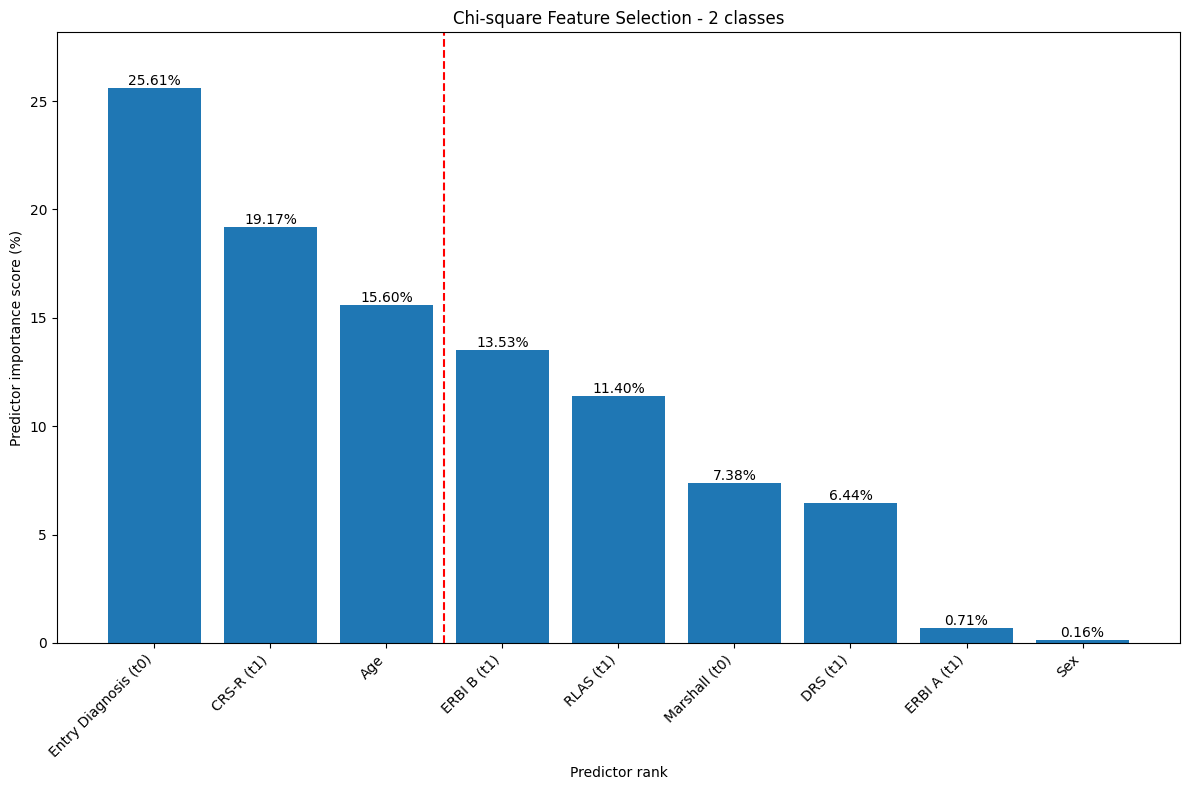

In [81]:
plot_chi2_feature_importances(X, y)

## Pearson Correlation

In [82]:
def select_features_pearson(X, threshold):
    col_corr = set()
    corr_matrix = X.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    selected_features = [col for col in X.columns if col not in col_corr]
    return selected_features

In [83]:
# Function to evaluate models with 10-fold cross-validation
def evaluate_model_cv(model, X, y, selected_features):
    X_selected = X[selected_features]
    scoring = {
        'accuracy': 'accuracy',
        'precision_micro': make_scorer(precision_score, average='micro'),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_micro': make_scorer(recall_score, average='micro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_micro': make_scorer(f1_score, average='micro'),
        'f1_macro': make_scorer(f1_score, average='macro')
    }
    return cross_validate(model, X_selected, y, cv=LeaveOneOut(), scoring=scoring)

In [84]:
# Function to summarize cross-validation results
def summarize_cv_results(cv_results):
    return {metric: np.mean(cv_results[f'test_{metric}']) for metric in 
            ['accuracy', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro']}

In [85]:
# Main script
def results_pearson(models, X, y, thresholds):
    results_list = []
    
    # Transform X and y
    X_transformed, y_transformed = transform_data(X, y)
    
    for threshold in thresholds:
        selected_features = select_features_pearson(X_transformed, threshold)
        
        for model_name, model in models:
            if len(selected_features) > 0:
                cv_results = evaluate_model_cv(model, X_transformed, y_transformed, selected_features)
                summary = summarize_cv_results(cv_results)
                
                results_list.append({
                    "Model": model_name,
                    "Threshold": threshold,
                    "Number of Features": len(selected_features),
                    "Selected Features": selected_features,
                    **summary
                })
    
    return pd.DataFrame(results_list)

In [86]:
def plot_pearson_feature_importances(X, threshold):
    corr_matrix = X.corr().abs()
    
    # Tính trung bình tương quan của mỗi đặc trưng với các đặc trưng khác
    avg_correlation = corr_matrix.mean().sort_values(ascending=False)
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_correlation.index, y=avg_correlation.values)
    plt.title('Feature Importance based on Average Pearson Correlation')
    plt.xlabel('Features')
    plt.ylabel('Average Absolute Correlation')
    plt.xticks(rotation=90)
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [87]:
thresholds = [0.1, 0.2, 0.3, 0.5, 0.6, 0.9, 1.0]

In [88]:
results_pearson = results_pearson(models, X, y, thresholds)

In [89]:
results_pearson.head()

,Model,Threshold,Number of Features,Selected Features,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,Linear Regression,0.1000,2,"[Age, Sex]",0.6569,0.6569,0.6569,0.6569,0.6569,0.6569,0.6569
1,SVM (RBF),0.1000,2,"[Age, Sex]",0.7353,0.7353,0.7353,0.7353,0.7353,0.7353,0.7353
2,KNN (k=5),0.1000,2,"[Age, Sex]",0.6863,0.6863,0.6863,0.6863,0.6863,0.6863,0.6863
3,Naive Bayes,0.1000,2,"[Age, Sex]",0.6961,0.6961,0.6961,0.6961,0.6961,0.6961,0.6961
4,Decision Tree (max_depth=10),0.1000,2,"[Age, Sex]",0.6471,0.6471,0.6471,0.6471,0.6471,0.6471,0.6471


In [90]:
best_results_pearson = (results_pearson.loc[results_pearson.groupby('Model')['accuracy'].idxmax()]
                .sort_values(by="accuracy", ascending=False)
                .reset_index(drop=True))
best_results_pearson["Rank"] = best_results_pearson.index + 1
best_results_pearson = best_results_pearson[["Rank", "Model", "Threshold", "Selected Features", 
                             "accuracy", "precision_micro", "precision_macro", 
                             "recall_micro", "recall_macro", "f1_micro", "f1_macro"]]
pd.set_option('display.float_format', lambda x: '%.4f' % x)
best_results_pearson

,Rank,Model,Threshold,Selected Features,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,1,KNN (k=5),0.5000,"[Age, Sex, Marshall (t0), Entry Diagnosis (t0)...",0.8431,0.8431,0.8431,0.8431,0.8431,0.8431,0.8431
1,2,SVM (RBF),0.9000,"[Age, Sex, Marshall (t0), Entry Diagnosis (t0)...",0.8235,0.8235,0.8235,0.8235,0.8235,0.8235,0.8235
2,3,Linear Regression,1.0000,"[Age, Sex, Marshall (t0), Entry Diagnosis (t0)...",0.7843,0.7843,0.7843,0.7843,0.7843,0.7843,0.7843
3,4,Naive Bayes,0.9000,"[Age, Sex, Marshall (t0), Entry Diagnosis (t0)...",0.7745,0.7745,0.7745,0.7745,0.7745,0.7745,0.7745
4,5,Decision Tree (max_depth=10),0.9000,"[Age, Sex, Marshall (t0), Entry Diagnosis (t0)...",0.7647,0.7647,0.7647,0.7647,0.7647,0.7647,0.7647


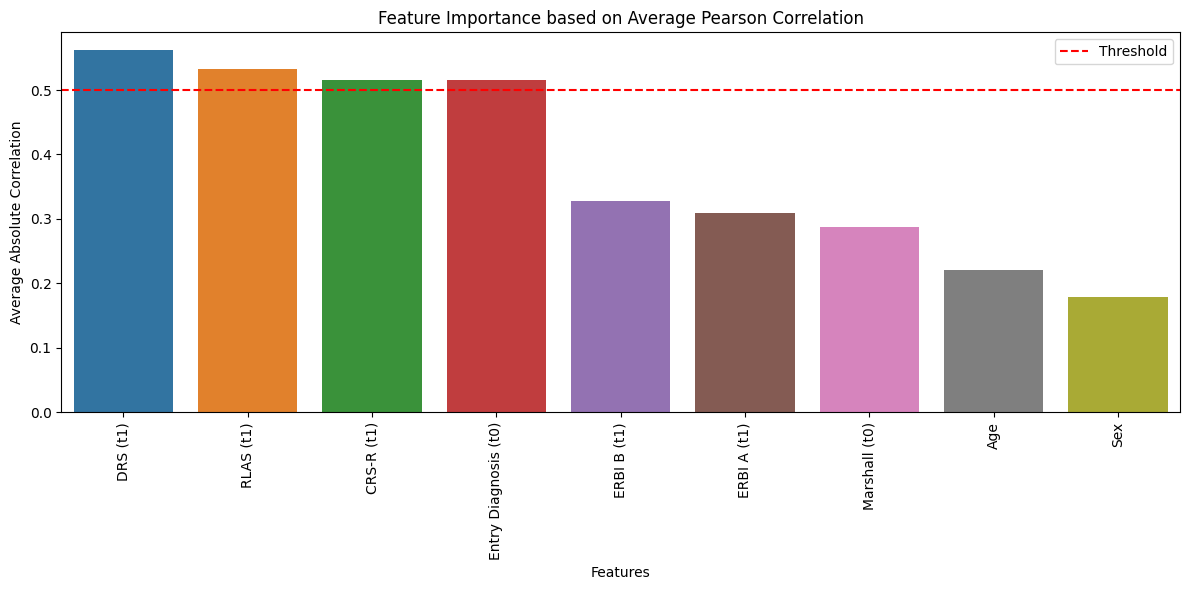

In [91]:
plot_pearson_feature_importances(X, threshold=0.5)

## SFS

In [92]:
X_transformed, y_transformed = transform_data(X, y)
                                              
results_sfs = []

# Fit the selector and calculate custom scores for each model
for model_name, model in models:
    sfs = SFS(estimator=model,
              k_features=(1, 9),
              forward=True,
              scoring='accuracy',
              cv=LeaveOneOut())
    sfs = sfs.fit(X_transformed, y_transformed)
    # Display the best score and selected features
    print(f'\nModel: {model_name}')
    print('Best acc score: %.4f' % sfs.k_score_)
    print('Best subset (indices):', sfs.k_feature_idx_)
    print('Best subset (corresponding names):', sfs.k_feature_names_)
                                              
    # Lưu kết quả vào danh sách
    for k, score in zip(range(1, X_transformed.shape[1] + 1), sfs.get_metric_dict().values()):
        results_sfs.append({
            "Model": model_name,
            "Number of Features (K)": k,
            "Accuracy": score['avg_score']
        })
                                              


Model: Linear Regression
Best acc score: 0.8627
Best subset (indices): (0, 4, 6)
Best subset (corresponding names): ('Age', 'CRS-R (t1)', 'DRS (t1)')

Model: SVM (RBF)
Best acc score: 0.8431
Best subset (indices): (0, 3, 6)
Best subset (corresponding names): ('Age', 'Entry Diagnosis (t0)', 'DRS (t1)')

Model: KNN (k=5)
Best acc score: 0.8529
Best subset (indices): (0, 2, 3, 4, 5, 6, 7, 8)
Best subset (corresponding names): ('Age', 'Marshall (t0)', 'Entry Diagnosis (t0)', 'CRS-R (t1)', 'RLAS (t1)', 'DRS (t1)', 'ERBI A (t1)', 'ERBI B (t1)')

Model: Naive Bayes
Best acc score: 0.8235
Best subset (indices): (0, 5, 6)
Best subset (corresponding names): ('Age', 'RLAS (t1)', 'DRS (t1)')

Model: Decision Tree (max_depth=10)
Best acc score: 0.7941
Best subset (indices): (0, 1, 3, 5, 6)
Best subset (corresponding names): ('Age', 'Sex', 'Entry Diagnosis (t0)', 'RLAS (t1)', 'DRS (t1)')


In [93]:
results_sfs_df = pd.DataFrame(results_sfs)

In [94]:
results_sfs_df.head()

,Model,Number of Features (K),Accuracy
0,Linear Regression,1,0.7255
1,Linear Regression,2,0.8235
2,Linear Regression,3,0.8627
3,Linear Regression,4,0.8627
4,Linear Regression,5,0.8529


## SBS

In [95]:
X_transformed, y_transformed = transform_data(X, y)

results_sbs = []

# Fit the selector and calculate custom scores for each model
for model_name, model in models:
    sbs = SFS(estimator=model,
              k_features=(1, 9),
              forward=False,
              scoring='accuracy',
              cv=LeaveOneOut())
    sbs = sbs.fit(X_transformed, y_transformed)
    # Display the best score and selected features
    print(f'\nModel: {model_name}')
    print('Best acc score: %.4f' % sbs.k_score_)
    print('Best subset (indices):', sbs.k_feature_idx_)
    print('Best subset (corresponding names):', sbs.k_feature_names_)
    
    # Lưu kết quả vào danh sách
    for k, score in zip(range(X_transformed.shape[1], 0, -1), sbs.get_metric_dict().values()):  # Duyệt ngược từ số features tối đa
        results_sbs.append({
            "Model": model_name,
            "Number of Features (K)": k,
            "Accuracy": score['avg_score'] 
        })


Model: Linear Regression
Best acc score: 0.8627
Best subset (indices): (0, 1, 4, 6)
Best subset (corresponding names): ('Age', 'Sex', 'CRS-R (t1)', 'DRS (t1)')

Model: SVM (RBF)
Best acc score: 0.8725
Best subset (indices): (0, 1, 4, 5, 6, 8)
Best subset (corresponding names): ('Age', 'Sex', 'CRS-R (t1)', 'RLAS (t1)', 'DRS (t1)', 'ERBI B (t1)')

Model: KNN (k=5)
Best acc score: 0.8627
Best subset (indices): (0, 2, 4, 5, 6, 7, 8)
Best subset (corresponding names): ('Age', 'Marshall (t0)', 'CRS-R (t1)', 'RLAS (t1)', 'DRS (t1)', 'ERBI A (t1)', 'ERBI B (t1)')

Model: Naive Bayes
Best acc score: 0.8431
Best subset (indices): (0, 3, 4, 8)
Best subset (corresponding names): ('Age', 'Entry Diagnosis (t0)', 'CRS-R (t1)', 'ERBI B (t1)')

Model: Decision Tree (max_depth=10)
Best acc score: 0.8039
Best subset (indices): (0, 2, 3, 6, 8)
Best subset (corresponding names): ('Age', 'Marshall (t0)', 'Entry Diagnosis (t0)', 'DRS (t1)', 'ERBI B (t1)')


In [96]:
results_sbs_df = pd.DataFrame(results_sbs)

In [97]:
results_sbs_df.head()

,Model,Number of Features (K),Accuracy
0,Linear Regression,9,0.7843
1,Linear Regression,8,0.8333
2,Linear Regression,7,0.8529
3,Linear Regression,6,0.8529
4,Linear Regression,5,0.8431


## Visualization

### 1. Without Feature Selection

In [98]:
def plot_results_no_fs(results_df):
    metrics = ['accuracy']
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(data=results_df, x='Model', y=metric, palette='viridis')
        plt.title(f'{metric.capitalize()} for Different Models (No Feature Selection)', fontsize=16)
        plt.xlabel('Model', fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        
        # Adding detail numbers on bars
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height:.4f}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points', 
                        fontsize=12, color='black', weight='bold')
        
        # Identify the highest accuracy and the corresponding model
        max_accuracy = results_df[metric].max()
        best_model = results_df.loc[results_df[metric].idxmax(), 'Model']
        
        plt.tight_layout()

        # Adding annotation outside the plot area
        plt.figtext(0.5, -0.05, f'Best Model: {best_model}, Accuracy: {max_accuracy:.4f}', 
                    wrap=True, horizontalalignment='center', fontsize=14, color='red', weight='bold')
        
        plt.show()

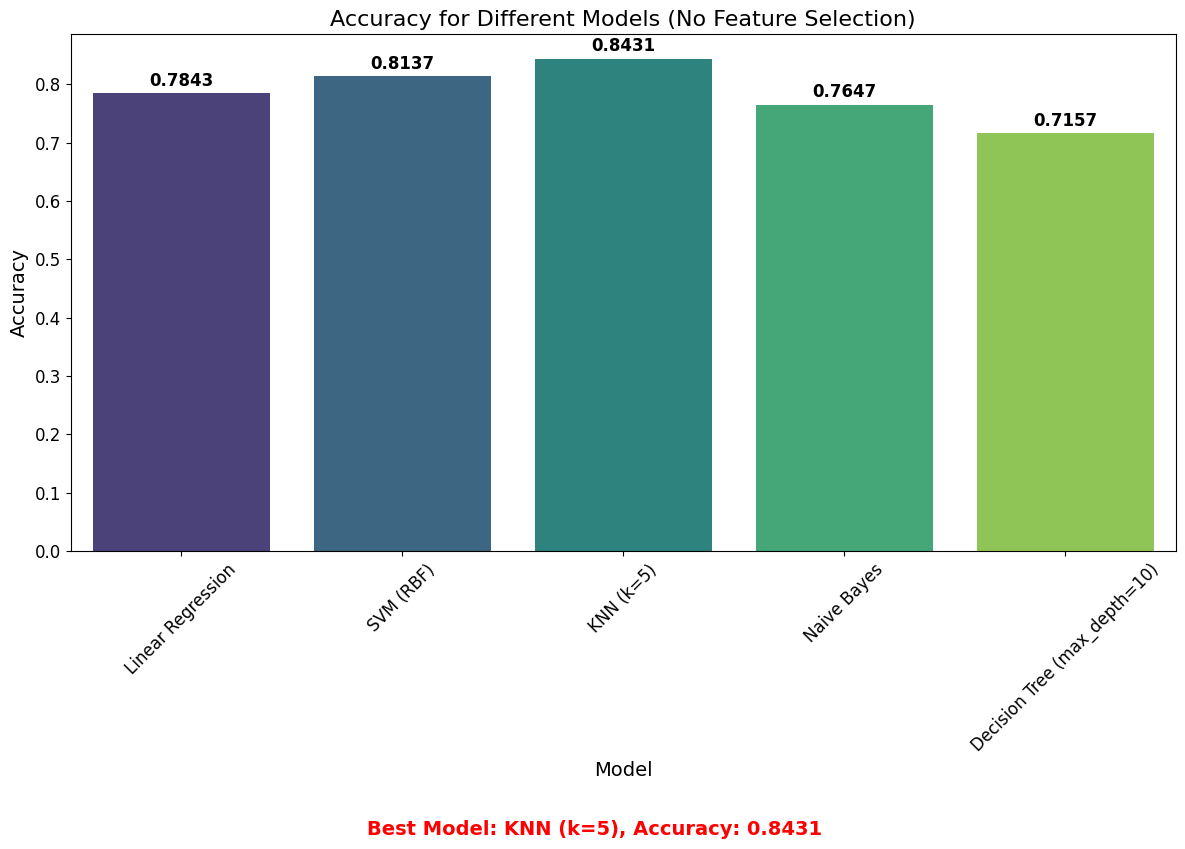

In [99]:
plot_results_no_fs(results_without_fs)

### 2. MRMR

In [100]:
def plot_results_mrmr(results_df):
    metrics = ['accuracy']
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        ax = sns.lineplot(data=results_df, x='K', y=metric, hue='Model', marker='o', palette='tab10')
        plt.title(f'{metric.capitalize()} vs. Number of Features (MRMR)', fontsize=16)
        plt.xlabel('Number of Features (K)', fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title='Model', fontsize=12, title_fontsize='13')
        
        # Adding detail numbers on points
        for line in ax.lines:
            for x, y in zip(line.get_xdata(), line.get_ydata()):
                ax.annotate(f'{y:.4f}', 
                            (x, y), 
                            textcoords="offset points", 
                            xytext=(0, 5), 
                            ha='center', fontsize=10, color='black', weight='bold')

        # Finding and annotating the best score
        best_score = results_df[metric].max()
        best_row = results_df.loc[results_df[metric].idxmax()]
        best_model = best_row['Model']
        best_k = best_row['K']
        
        plt.figtext(0.5, -0.05, f'Best {metric.capitalize()}: {best_score:.4f} (Model: {best_model}, K={best_k})',
                    wrap=True, horizontalalignment='center', fontsize=14, color='red', weight='bold')
        
        plt.grid(True)
        plt.tight_layout()
        plt.show()

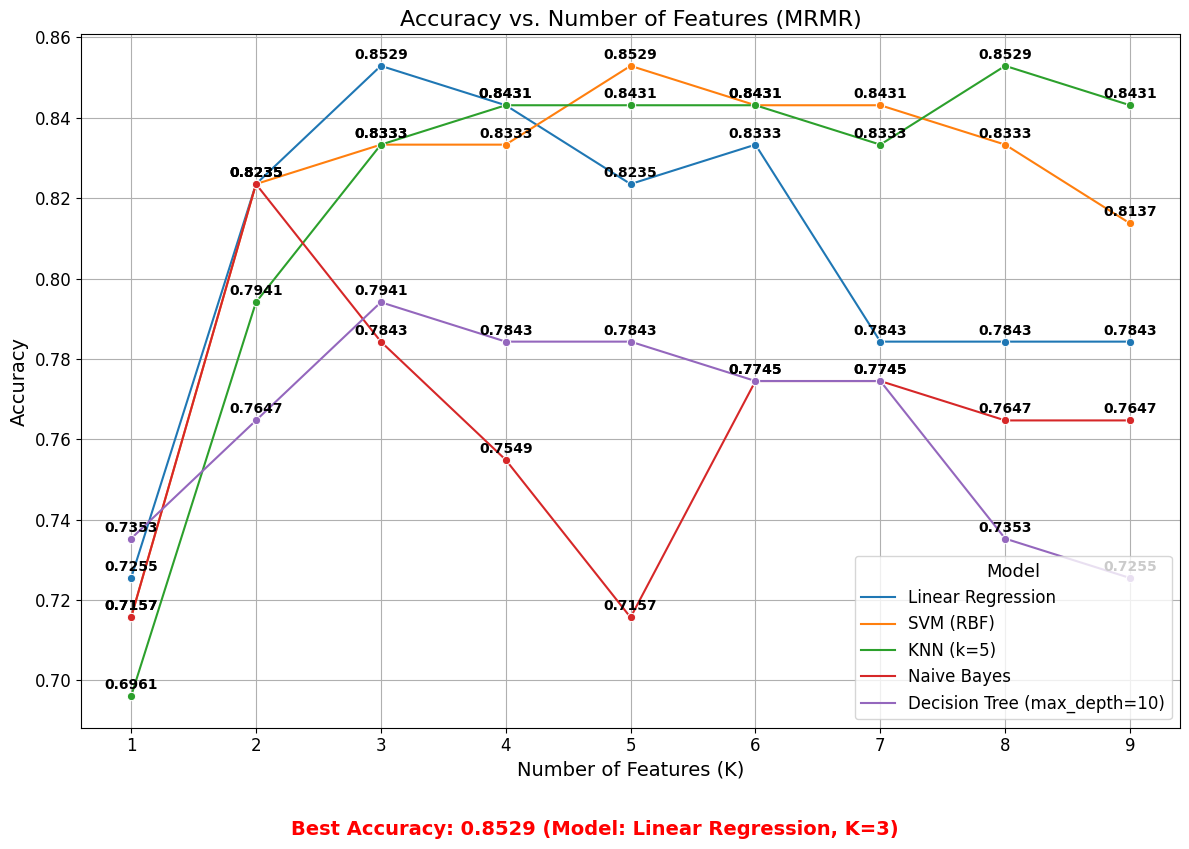

In [101]:
plot_results_mrmr(results_mrmr)

### 3. Chi-squared Test

In [102]:
def plot_results_chi2(results_df):
    metrics = ['accuracy']
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        ax = sns.lineplot(data=results_df, x='K', y=metric, hue='Model', marker='o', palette='tab10')
        plt.title(f'{metric.capitalize()} vs. Number of Features (Chi2)', fontsize=16)
        plt.xlabel('Number of Features (K)', fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title='Model', fontsize=12, title_fontsize='13')
        
        # Adding detail numbers on points
        for line in ax.lines:
            for x, y in zip(line.get_xdata(), line.get_ydata()):
                ax.annotate(f'{y:.4f}', 
                            (x, y), 
                            textcoords="offset points", 
                            xytext=(0, 5), 
                            ha='center', fontsize=10, color='black', weight='bold')

        # Finding and annotating the best score
        best_score = results_df[metric].max()
        best_row = results_df.loc[results_df[metric].idxmax()]
        best_model = best_row['Model']
        best_k = best_row['K']
        
        plt.figtext(0.5, -0.05, f'Best {metric.capitalize()}: {best_score:.4f} (Model: {best_model}, K={best_k})',
                    wrap=True, horizontalalignment='center', fontsize=14, color='red', weight='bold')
        
        plt.grid(True)
        plt.tight_layout()
        plt.show()

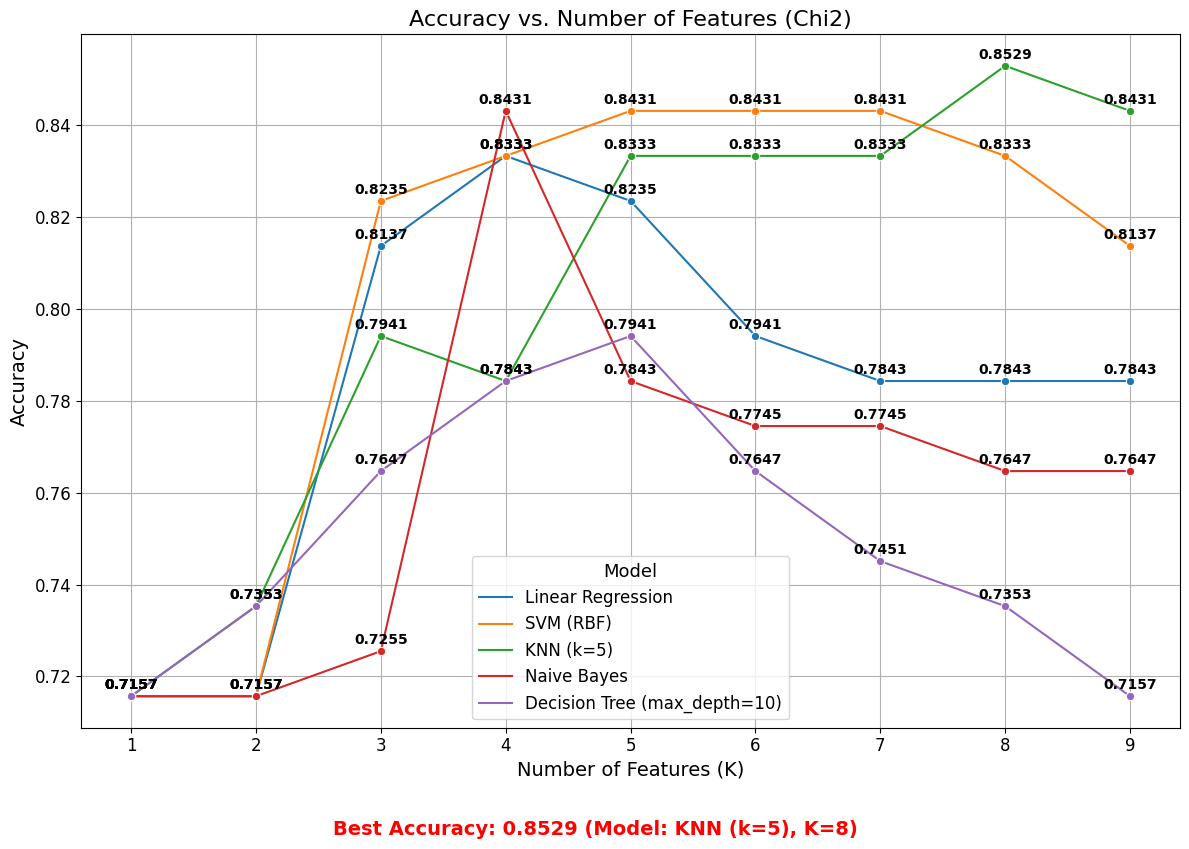

In [103]:
plot_results_chi2(results_chi2)

### 4. Pearson Correlation

In [104]:
def plot_results_pearson(results_df):
    metrics = ['accuracy']  # Hoặc các metrics khác bạn muốn hiển thị
    for metric in metrics:
        plt.figure(figsize=(12, 8))

        # Lọc các mô hình duy nhất
        unique_models = results_df['Model'].unique()
        palette = sns.color_palette("tab10", n_colors=len(unique_models))  # Tạo bảng màu

        for i, model in enumerate(unique_models):
            model_data = results_df[results_df['Model'] == model]  # Lọc dữ liệu cho từng mô hình

            # Vẽ biểu đồ đường (không có vùng tô)
            sns.lineplot(
                data=model_data,
                x='Threshold',  # Sử dụng 'Threshold' làm trục X
                y=metric,
                marker='o',
                label=model,
                color=palette[i],  # Gán màu cho từng mô hình
                ci=None  # Loại bỏ vùng tin cậy (confidence interval)
            )

            # Thêm số chi tiết trên mỗi điểm
            for x, y in zip(model_data['Threshold'], model_data[metric]):
                plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0, 5),
                             ha='center', fontsize=10, color='black', weight='bold')

        # Tìm và chú thích kết quả tốt nhất
        best_score = results_df[metric].max()
        best_row = results_df.loc[results_df[metric].idxmax()]
        best_model = best_row['Model']
        best_threshold = best_row['Threshold']
        
        plt.figtext(0.5, -0.05, f'Best {metric.capitalize()}: {best_score:.4f} (Model: {best_model}, Threshold={best_threshold})',
                    wrap=True, horizontalalignment='center', fontsize=14, color='red', weight='bold')

        plt.title(f'{metric.capitalize()} vs. Pearson Correlation Threshold', fontsize=16)  
        plt.xlabel('Pearson Correlation Threshold', fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title='Model', fontsize=12, title_fontsize=13)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


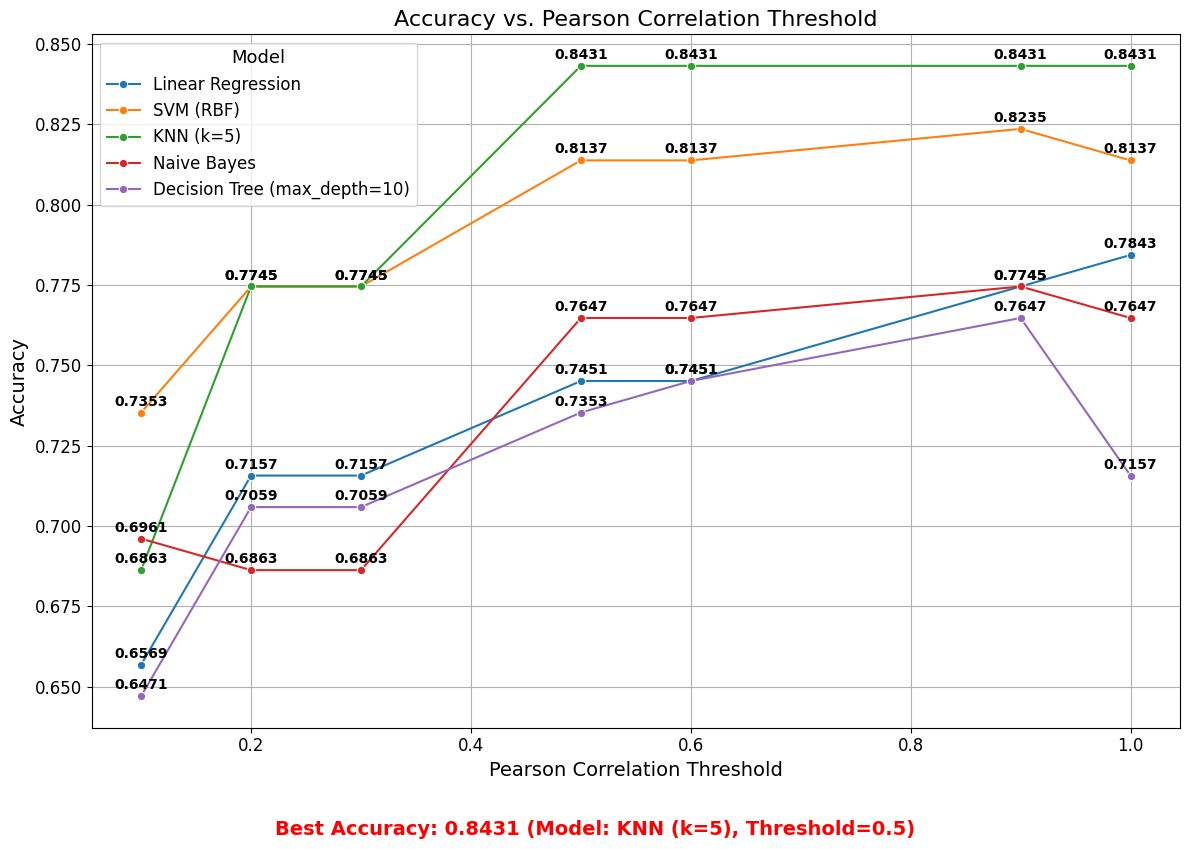

In [105]:
plot_results_pearson(results_pearson)

### 5. SFS

In [106]:
def plot_results_sfs(results_df):
    plt.figure(figsize=(12, 8))
    unique_models = results_df['Model'].unique()
    palette = sns.color_palette("tab10", n_colors=len(unique_models))  # Tạo bảng màu

    for i, model in enumerate(unique_models):
        model_data = results_df[results_df['Model'] == model]  # Lọc dữ liệu cho từng mô hình
        sns.lineplot(
            data=model_data,
            x='Number of Features (K)',
            y='Accuracy',  # Giả sử bạn dùng 'accuracy'
            marker='o',
            label=model,
            color=palette[i]
        )

        # Thêm số chi tiết trên mỗi điểm
        for x, y in zip(model_data['Number of Features (K)'], model_data['Accuracy']):
            plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0, 5),
                         ha='center', fontsize=10, color='black', weight='bold')

    # Tìm và chú thích kết quả tốt nhất
    best_score = results_df['Accuracy'].max()
    best_row = results_df.loc[results_df['Accuracy'].idxmax()]
    best_model = best_row['Model']
    best_k = best_row['Number of Features (K)']
    
    plt.figtext(0.5, -0.05, f'Best Accuracy: {best_score:.4f} (Model: {best_model}, Number of Features (K)={best_k})',
                wrap=True, horizontalalignment='center', fontsize=14, color='red', weight='bold')

    plt.title('Accuracy vs. Number of Features (SFS)', fontsize=16)
    plt.xlabel('Number of Features (K)', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Model', fontsize=12, title_fontsize=13)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

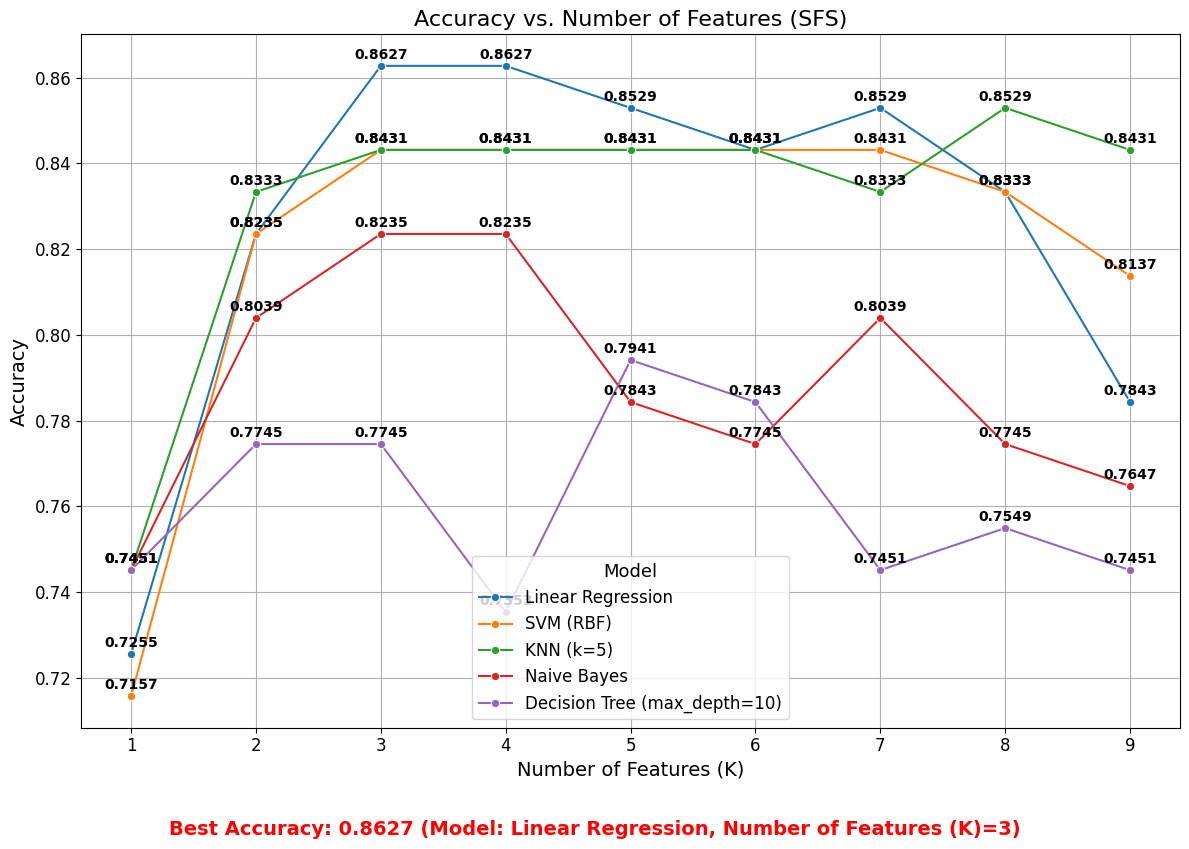

In [107]:
plot_results_sfs(results_sfs_df)

### 6. SBS

In [108]:
def plot_results_sbs(results_df):
    plt.figure(figsize=(12, 8))
    unique_models = results_df['Model'].unique()
    palette = sns.color_palette("tab10", n_colors=len(unique_models))  # Tạo bảng màu

    for i, model in enumerate(unique_models):
        model_data = results_df[results_df['Model'] == model]  # Lọc dữ liệu cho từng mô hình
        sns.lineplot(
            data=model_data,
            x='Number of Features (K)',
            y='Accuracy',  # Giả sử bạn dùng 'accuracy'
            marker='o',
            label=model,
            color=palette[i]
        )

        # Thêm số chi tiết trên mỗi điểm
        for x, y in zip(model_data['Number of Features (K)'], model_data['Accuracy']):
            plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0, 5),
                         ha='center', fontsize=10, color='black', weight='bold')

    # Tìm và chú thích kết quả tốt nhất
    best_score = results_df['Accuracy'].max()
    best_row = results_df.loc[results_df['Accuracy'].idxmax()]
    best_model = best_row['Model']
    best_k = best_row['Number of Features (K)']
    
    plt.figtext(0.5, -0.05, f'Best Accuracy: {best_score:.4f} (Model: {best_model}, Number of Features (K)={best_k})',
                wrap=True, horizontalalignment='center', fontsize=14, color='red', weight='bold')

    plt.title('Accuracy vs. Number of Features (SBS)', fontsize=16)
    plt.xlabel('Number of Features (K)', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().invert_xaxis()  # Đảo ngược trục x cho SBS
    plt.legend(title='Model', fontsize=12, title_fontsize=13)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

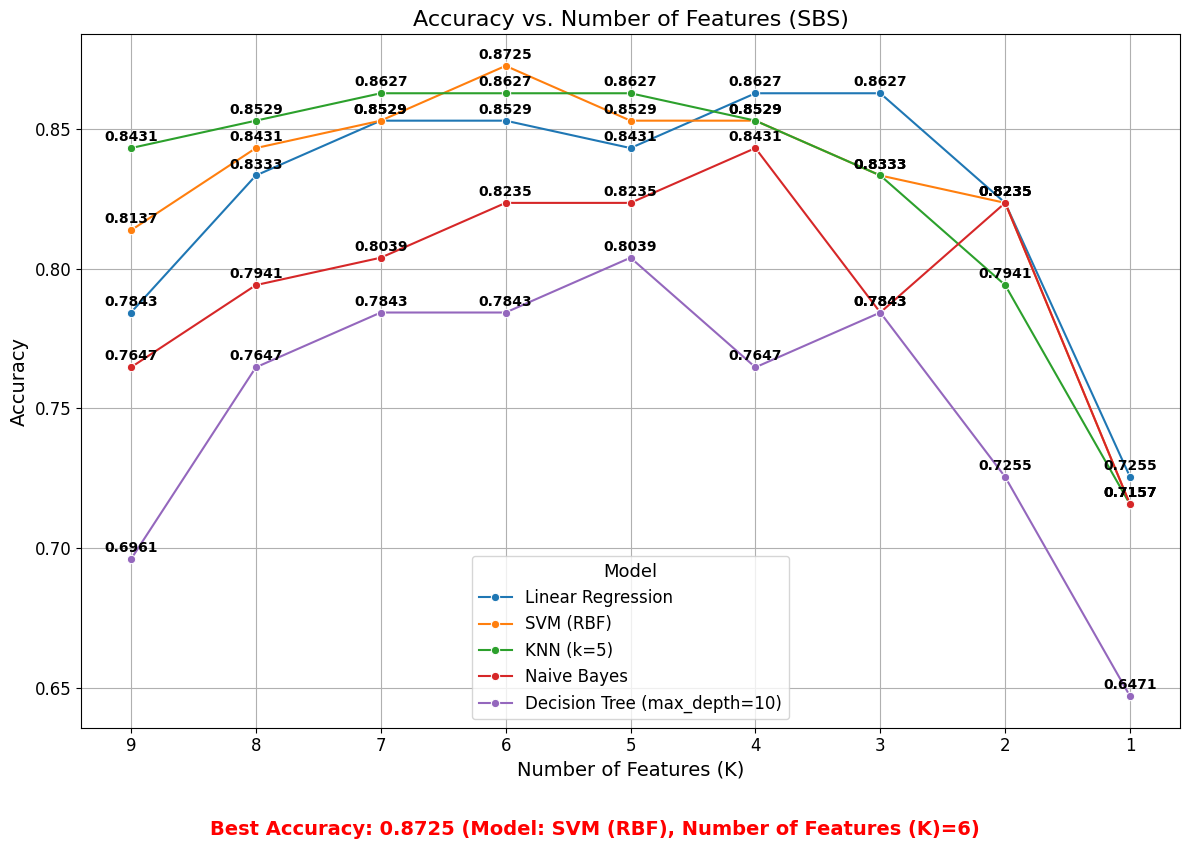

In [109]:
plot_results_sbs(results_sbs_df)

# Interface

In [173]:
import joblib
import ipywidgets as widgets
from IPython.display import display, HTML

In [193]:
# Lưu kết quả tốt nhất
best_result = {
    "Model": "",
    "Best Accuracy": 0,
    "Best Features": [],
    "Number of Features": 0
}

best_model = None

for model_name, model in models:
    sbs = SFS(estimator=model,
              k_features=(1, 9),
              forward=False,
              scoring='accuracy',
              cv=LeaveOneOut())
    sbs = sbs.fit(X_transformed, y_transformed)
    
    if sbs.k_score_ > best_result["Best Accuracy"]:
        best_result = {
            "Model": model_name,
            "Best Accuracy": sbs.k_score_,
            "Best Features": list(sbs.k_feature_names_),
            "Number of Features": len(sbs.k_feature_names_)
        }
        
        best_model = model.fit(X_transformed[list(sbs.k_feature_names_)], y_transformed)

# Lưu model tốt nhất đã được huấn luyện
if best_model is not None:
    joblib.dump(best_model, 'best_model.joblib')

# Lưu thông tin về model tốt nhất
pd.DataFrame([best_result]).to_csv('best_model_info.csv', index=False)

In [194]:
def predict_gos_e(input_data):
    # Đọc thông tin về model tốt nhất
    best_model_info = pd.read_csv('best_model_info.csv')
    best_features = eval(best_model_info['Best Features'][0])
    
    # Tải model tốt nhất
    model = joblib.load('/kaggle/working/best_model.joblib')
    
    # Chuẩn bị dữ liệu đầu vào
    input_df = pd.DataFrame([input_data])
    
    # Kiểm tra xem tất cả các feature cần thiết có trong input không
    missing_features = set(best_features) - set(input_data.keys())
    if missing_features:
        raise ValueError(f"Missing features: {missing_features}")
    
    # Đọc dữ liệu gốc để chuẩn hóa
    original_data = pd.read_csv('/kaggle/input/tbi-dataset/filledata.csv')
    
    # Chuẩn hóa dữ liệu đầu vào
    scaler = MinMaxScaler()
    scaler.fit(original_data[best_features])
    input_transformed = scaler.transform(input_df[best_features])
    
    # Thực hiện dự đoán
    prediction = model.predict(input_transformed)
    
    return prediction[0]

In [196]:
def create_user_interface():
    # Đọc thông tin về model tốt nhất
    best_model_info = pd.read_csv('best_model_info.csv')
    best_features = eval(best_model_info['Best Features'][0])

    feature_ranges = {
        'Age': (0, 120),
        'Sex': (0, 1),
        'Marshall (t0)': (1, 6),
        'Entry Diagnosis (t0)': (1, 3),
        'CRS-R (t1)': (0, 23),
        'RLAS (t1)': (1, 8),
        'DRS (t1)': (0, 29),
        'ERBI A (t1)': (-325, 100),
        'ERBI B (t1)': (-325, 100)
    }
    
    feature_descriptions = {
        'Age': "Age (0-120)",
        'Sex': "Sex (0 for Female, 1 for Male)",
        'Marshall (t0)': "Marshall (t0) classification (1-6)",
        'Entry Diagnosis (t0)': "Entry Diagnosis (t0) (1 for VS, 2 for MCS, 3 for EMERSION)",
        'CRS-R (t1)': "CRS-R (t1) score (0-23)",
        'RLAS (t1)': "RLAS level (t1) (1-8)",
        'DRS (t1)': "DRS score (t1) (0-29)",
        'ERBI A (t1)': "ERBI A score (t1) (-325 to 100)",
        'ERBI B (t1)': "ERBI B score (t1) (-325 to 100)"
    }

    widgets_dict = {}
    for feature in best_features:
        min_val, max_val = feature_ranges[feature]
        slider = widgets.IntSlider(
            value=min_val,
            min=min_val,
            max=max_val,
            step=1,
            description='',
            continuous_update=False,
            layout=widgets.Layout(width='60%')
        )
        
        text = widgets.BoundedIntText(
            value=min_val,
            min=min_val,
            max=max_val,
            step=1,
            description='',
            disabled=False,
            layout=widgets.Layout(width='20%')
        )
        
        widgets.jslink((slider, 'value'), (text, 'value'))
        
        label = widgets.Label(feature_descriptions[feature], layout=widgets.Layout(width='20%'))
        
        box = widgets.HBox([label, slider, text], layout=widgets.Layout(margin='10px 0px'))
        widgets_dict[feature] = box

    predict_button = widgets.Button(
        description="Predict",
        button_style='success',
        layout=widgets.Layout(width='20%', margin='20px 0px')
    )
    output = widgets.Output(layout=widgets.Layout(margin='20px 0px'))

    def on_button_clicked(b):
        with output:
            output.clear_output()
            input_data = {feature: box.children[1].value for feature, box in widgets_dict.items()}
            try:
                predicted_gos_e = predict_gos_e(input_data)
                print(f"Predicted GOS-E (t2): {predicted_gos_e}")
            except Exception as e:
                print(f"An error occurred: {str(e)}")

    predict_button.on_click(on_button_clicked)

    title = widgets.HTML("<h2>TBI Prediction Interface</h2>")
    ui = widgets.VBox([title] + list(widgets_dict.values()) + [predict_button, output], 
                      layout=widgets.Layout(width='80%', margin='0 auto'))
    
    # Add some CSS styling
    display(HTML("""
    <style>
        .widget-label {
            min-width: 200px;
            max-width: 200px;
            text-align: right;
            margin-right: 10px;
        }
        .widget-readout {
            min-width: 60px;
            max-width: 60px;
        }
        .widget-slider {
            width: 300px;
        }
        .widget-text {
            width: 60px;
        }
    </style>
    """))
    
    display(ui)

# Sử dụng giao diện
create_user_interface()